In [1]:
!pip install tensorflow boto3 scikit-learn pandas matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
!pip install ultralytics

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 68.4 MB/s eta 0:00:00
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [3]:
!pip install boto3 tensorflow scikit-learn matplotlib seaborn tqdm torch torchvision

In [4]:
!pip install boto3 tensorflow scikit-learn matplotlib pillow tqdm seaborn

In [5]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)


In [6]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


#Code Version1

In [16]:
import boto3
import os
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tqdm import tqdm
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import warnings
import datetime
import torch
import json

warnings.filterwarnings("ignore")

# Conditional import of cv2
try:
    import cv2
    OPENCV_AVAILABLE = True
except ImportError:
    print("OpenCV (cv2) not found. Functionality requiring OpenCV will be disabled.")
    OPENCV_AVAILABLE = False

# Conditional import of YOLO
try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except ImportError:
    print("Ultralytics YOLO not found. Functionality requiring YOLO will be disabled.")
    YOLO_AVAILABLE = False


class DentalXrayAnalysisSystem:
    def __init__(self, bucket_name, dataset_prefix, output_prefix):
        self.s3 = boto3.client('s3')
        self.bucket_name = bucket_name
        self.dataset_prefix = dataset_prefix
        self.output_prefix = output_prefix
        self.target_size = (256, 256)
        self.batch_size = 32
        self.disease_classes = ['Broken Tooth/Root', 'Caries', 'Fractured Teeth', 'Healthy Teeth', 'Impacted Teeth', 'Infection', 'Periapical Lesion']
        self.log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if YOLO_AVAILABLE:
          try:
             self.yolo_model = YOLO('yolov8n.pt')
          except Exception as e:
             print(f"Error loading YOLO model: {e}")
             self.yolo_model = None
        else:
           self.yolo_model = None

    def preprocess_image(self, image_data):
      if not OPENCV_AVAILABLE:
          print("OpenCV not available, skipping preprocess_image.")
          return None, None
      try:
        nparr = np.frombuffer(image_data.read(), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        if img is None:
           raise ValueError("Failed to decode image")
        img = cv2.resize(img, self.target_size)
        normalized = img.astype('float32') / 255.0
        return img, normalized
      except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None


    def detect_teeth_yolo(self, img):
       if not YOLO_AVAILABLE or img is None or self.yolo_model is None:
          print("YOLO not available or image is None, skipping detect_teeth_yolo.")
          return []
       try:
           results = self.yolo_model(img)
           boxes = []
           if results and results[0].boxes:
              for *xyxy, conf, cls in results[0].boxes.data.tolist():
               if cls == 0: # Assuming teeth are class 0, check your YOLO training if this is correct.
                 x1, y1, x2, y2 = map(int, xyxy)
                 boxes.append((x1, y1, x2-x1, y2-y1))
           return boxes
       except Exception as e:
           print(f"Error during YOLO inference: {e}")
           return []


    def detect_pathology(self, img, teeth_boxes, filename, model=None):
        pathologies = {
            'Broken Tooth/Root': [], 'Caries': [], 'Fractured Teeth': [], 'Healthy Teeth': [], 'Impacted Teeth': [], 'Infection': [], 'Periapical Lesion': []
        }
        if not OPENCV_AVAILABLE or img is None or len(teeth_boxes) == 0:
            print("OpenCV not available or missing image data, skipping detect_pathology.")
            return pathologies

        try:
          gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()

          for x, y, w, h in teeth_boxes:
              x = max(0, min(x, gray.shape[1] - 1))
              y = max(0, min(y, gray.shape[0] - 1))
              w = min(w, gray.shape[1] - x)
              h = min(h, gray.shape[0] - y)
              tooth_roi = gray[y:y+h, x:x+w]
              if tooth_roi.size == 0:
                  continue
              tooth_roi = cv2.resize(tooth_roi, (64, 64))
              
              if model is not None:
                  roi_input = np.expand_dims(tooth_roi.astype('float32')/255.0, axis=(0, -1))
                  prediction = model.predict(roi_input)
                  predicted_class_index = np.argmax(prediction, axis=1)[0]
                  predicted_class = self.disease_classes[predicted_class_index]
                  prob = prediction[0][predicted_class_index]
                  pathologies[predicted_class].append({'probability': prob, 'location': (x, y, w, h), 'features': None})
              else: #fallback to rule based approach
                  features = self.extract_features(tooth_roi)
                  #Simplified Pathology detection based on features  -  REPLACE THIS WITH A TRAINED MODEL
                  if features['mean_intensity'] < 120 and features['contrast'] > 0.6 and features['energy'] < 0.3:
                      prob = min(0.95, features['contrast'] * 0.85 + (1 - features['energy']) * 0.7)
                      pathologies['Caries'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['mean_intensity'] < 90 and features['contrast'] > 0.8 and features['homogeneity'] < 0.25:
                      prob = min(0.98, features['contrast'] * 0.9 + (1 - features['homogeneity']) * 0.8)
                      pathologies['Caries'].append({'probability': prob, 'location': (x, y, w, h), 'features': features}) #was 'Deep Caries' - not in disease_classes
                  elif features['correlation'] < 0.4 and features['mean_intensity'] < 100 and features['std_intensity'] > 30:
                      prob = min(0.9, (1 - features['correlation']) * 0.75 + features['std_intensity'] / 100)
                      pathologies['Periapical Lesion'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['homogeneity'] > 0.8 and features['energy'] > 0.7 and features['mean_intensity'] > 160:
                      prob = min(0.9, features['homogeneity'] * 0.7 + features['energy'] * 0.3)
                      pathologies['Impacted Teeth'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['mean_intensity'] < 70 and features['std_intensity'] > 30 and features['contrast'] > 0.6 :
                       prob = min(0.95, features['std_intensity'] / 100 * 0.75 + features['contrast'] * 0.35)
                       pathologies['Broken Tooth/Root'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['mean_intensity'] > 130 and features['std_intensity'] < 10 and features['energy'] > 0.6 :
                     prob = min(0.92, features['mean_intensity']/200 * 0.55 + features['energy'] * 0.5)
                     pathologies['Healthy Teeth'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['mean_intensity'] < 110 and features['std_intensity'] > 25 and features['homogeneity'] < 0.4:
                      prob = min(0.88, (1 - features['homogeneity']) * 0.6 + features['std_intensity'] / 100 * 0.45)
                      pathologies['Infection'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  elif features['mean_intensity'] < 80 and features['std_intensity'] > 20 and features['correlation'] > 0.5:
                     prob = min(0.93, features['correlation'] * 0.6 + features['std_intensity'] / 100 * 0.4 )
                     pathologies['Fractured Teeth'].append({'probability': prob, 'location': (x, y, w, h), 'features': features})
                  else:
                      pathologies['Healthy Teeth'].append({'probability': 0.9, 'location': (x, y, w, h), 'features': features})
        except Exception as e:
            print(f"Error during pathology detection: {e}")
            return pathologies

        return pathologies

    def extract_features(self, roi):
      try:
           if np.std(roi) == 0:
              return {'contrast': 0, 'homogeneity': 0, 'correlation': 0, 'energy': 0, 'mean_intensity': 0, 'std_intensity': 0}
           distances = [1, 2, 3]
           angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
           glcm = graycomatrix(roi, distances, angles, 256, symmetric=True, normed=True)
           contrast = graycoprops(glcm, 'contrast').mean()
           homogeneity = graycoprops(glcm, 'homogeneity').mean()
           correlation = graycoprops(glcm, 'correlation').mean()
           energy = graycoprops(glcm, 'energy').mean()
           mean_intensity = np.mean(roi)
           std_intensity = np.std(roi)
           return {'contrast': contrast, 'homogeneity': homogeneity, 'correlation': correlation,
                    'energy': energy, 'mean_intensity': mean_intensity, 'std_intensity': std_intensity}
      except ValueError as e:
           print(f"Warning: GLCM calculation failed for ROI. Error: {e}")
           return {'contrast': 0, 'homogeneity': 0, 'correlation': 0, 'energy': 0, 'mean_intensity': 0, 'std_intensity': 0}

    def process_images(self):
        print("Processing images...")
        try:
           prefix = os.path.join(self.dataset_prefix)
           paginator = self.s3.get_paginator('list_objects_v2')
           for page in paginator.paginate(Bucket=self.bucket_name, Prefix=prefix):
              if 'Contents' not in page:
                continue
              for obj in tqdm(page['Contents'], desc=f"Processing Images"):
                  key = obj['Key']
                  if not key.lower().endswith(('jpg', 'jpeg', 'png')):
                       continue
                  try:
                     response = self.s3.get_object(Bucket=self.bucket_name, Key=key)
                     img_data = BytesIO(response['Body'].read())
                     original_img, processed_img = self.preprocess_image(img_data)
                     if processed_img is None:
                        continue
                     self.analyze_and_store(original_img, key)
                  except Exception as e:
                        print(f"Error processing {key}: {str(e)}")
                        continue
        except Exception as e:
            print(f"Error in process_images: {e}")

    def analyze_and_store(self, img, filename):
      if not OPENCV_AVAILABLE:
          print("OpenCV not available, skipping analyze_and_store.")
          return

      if img is None:
          return

      teeth_boxes = self.detect_teeth_yolo(img)
      pathologies = self.detect_pathology(img, teeth_boxes, filename)

      output_data = {
          'filename': filename,
          'teeth_data': []
      }

      try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
        for x, y, w, h in teeth_boxes:
            x = max(0, min(x, gray.shape[1] - 1))
            y = max(0, min(y, gray.shape[0] - 1))
            w = min(w, gray.shape[1] - x)
            h = min(h, gray.shape[0] - y)
            tooth_roi = gray[y:y + h, x:x + w]
            if tooth_roi.size == 0:
                continue
            tooth_roi_resized = cv2.resize(tooth_roi, (64, 64))

            for disease, detections in pathologies.items():
                for detection in detections:
                    if detection['location'] == (x, y, w, h):
                        tooth_data = {
                            'location': (x, y, w, h),
                            'disease': disease,
                            'probability': detection['probability'],
                            'features': detection['features']
                        }

                        output_data['teeth_data'].append(tooth_data)
                        # Store each tooth image to S3
                        _, buffer = cv2.imencode('.jpg', tooth_roi_resized)
                        try:
                            output_key = os.path.join(self.output_prefix, os.path.splitext(os.path.basename(filename))[0],
                                                      f'tooth_{x}_{y}_{w}_{h}.jpg')
                            self.s3.put_object(Bucket=self.bucket_name, Key=output_key, Body=buffer.tobytes())
                        except Exception as e:
                            print(f"Failed to upload tooth image: {e}")
      except Exception as e:
          print(f"Error during image processing in analyze_and_store: {e}")

      # Store the analysis mapping for the image as a json file
      try:
          output_key = os.path.join(self.output_prefix, os.path.splitext(os.path.basename(filename))[0],
                                    f'diagnosis_mapping.json')
          self.s3.put_object(Bucket=self.bucket_name, Key=output_key, Body=json.dumps(output_data))
      except Exception as e:
          print(f"Failed to store json mapping: {e}")

def main():
    bucket_name = "sagemaker-studio-010526272250-hsf94lgtf6i"
    dataset_prefix = "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/" # Modified to look into ground truth data
    output_prefix = "Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data" # Path where tooth level analysis will be stored

    try:
        session = boto3.Session()
        credentials = session.get_credentials()
        print(f"AWS Credentials: {credentials}")

        analyzer = DentalXrayAnalysisSystem(bucket_name, dataset_prefix, output_prefix)
        analyzer.process_images() # only process images
        print("Analysis Complete.")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

OpenCV (cv2) not found. Functionality requiring OpenCV will be disabled.
Ultralytics YOLO not found. Functionality requiring YOLO will be disabled.
AWS Credentials: <botocore.credentials.RefreshableCredentials object at 0x7f4b7357e650>
Processing images...


Processing Images:   0%|          | 2/517 [00:00<00:43, 11.77it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   1%|          | 6/517 [00:00<00:34, 14.77it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   2%|▏         | 10/517 [00:00<00:36, 13.72it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   3%|▎         | 14/517 [00:00<00:34, 14.66it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   3%|▎         | 16/517 [00:01<00:35, 14.09it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   4%|▍         | 20/517 [00:01<00:34, 14.27it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   5%|▍         | 24/517 [00:01<00:35, 14.02it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   5%|▌         | 28/517 [00:02<00:35, 13.91it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   6%|▌         | 32/517 [00:02<00:30, 15.73it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   7%|▋         | 34/517 [00:02<00:30, 15.95it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   7%|▋         | 38/517 [00:02<00:34, 14.03it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   8%|▊         | 42/517 [00:02<00:33, 14.30it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   9%|▉         | 46/517 [00:03<00:31, 15.11it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:   9%|▉         | 48/517 [00:03<00:31, 14.83it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  10%|█         | 52/517 [00:03<00:31, 14.72it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  11%|█         | 56/517 [00:03<00:31, 14.57it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  12%|█▏        | 60/517 [00:04<00:29, 15.72it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  12%|█▏        | 64/517 [00:04<00:28, 15.64it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  13%|█▎        | 66/517 [00:04<00:29, 15.26it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  14%|█▎        | 70/517 [00:04<00:31, 14.37it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  14%|█▍        | 72/517 [00:04<00:30, 14.57it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  15%|█▍        | 76/517 [00:05<00:30, 14.24it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  15%|█▌        | 80/517 [00:05<00:31, 14.06it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  16%|█▌        | 82/517 [00:05<00:30, 14.15it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  17%|█▋        | 86/517 [00:05<00:30, 14.25it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  17%|█▋        | 88/517 [00:06<00:28, 14.93it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  18%|█▊        | 92/517 [00:06<00:31, 13.47it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  19%|█▊        | 96/517 [00:06<00:29, 14.10it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  19%|█▉        | 98/517 [00:06<00:28, 14.95it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  20%|█▉        | 102/517 [00:07<00:30, 13.82it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  20%|██        | 104/517 [00:07<00:28, 14.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  21%|██        | 108/517 [00:07<00:29, 13.83it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  22%|██▏       | 112/517 [00:07<00:27, 14.88it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  22%|██▏       | 114/517 [00:07<00:27, 14.92it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  23%|██▎       | 118/517 [00:08<00:27, 14.49it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  24%|██▎       | 122/517 [00:08<00:26, 15.14it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  24%|██▍       | 126/517 [00:08<00:25, 15.52it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  25%|██▍       | 128/517 [00:08<00:26, 14.68it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  26%|██▌       | 132/517 [00:09<00:26, 14.70it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  26%|██▌       | 134/517 [00:09<00:27, 13.96it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  27%|██▋       | 138/517 [00:09<00:25, 14.78it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  27%|██▋       | 142/517 [00:09<00:25, 14.81it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  28%|██▊       | 146/517 [00:10<00:24, 15.26it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  29%|██▊       | 148/517 [00:10<00:25, 14.43it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  29%|██▉       | 152/517 [00:10<00:26, 13.73it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  30%|███       | 156/517 [00:10<00:25, 14.17it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  31%|███       | 158/517 [00:10<00:24, 14.83it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  31%|███▏      | 162/517 [00:11<00:25, 14.04it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  32%|███▏      | 164/517 [00:11<00:28, 12.23it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  32%|███▏      | 168/517 [00:11<00:28, 12.17it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  33%|███▎      | 170/517 [00:11<00:28, 12.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  34%|███▎      | 174/517 [00:12<00:27, 12.56it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  34%|███▍      | 176/517 [00:12<00:27, 12.60it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  35%|███▍      | 180/517 [00:12<00:25, 13.13it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  35%|███▌      | 182/517 [00:12<00:26, 12.74it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  36%|███▌      | 186/517 [00:13<00:24, 13.27it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  37%|███▋      | 190/517 [00:13<00:21, 15.01it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  38%|███▊      | 194/517 [00:13<00:20, 16.01it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  38%|███▊      | 198/517 [00:13<00:21, 15.04it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  39%|███▊      | 200/517 [00:14<00:24, 13.16it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  39%|███▉      | 204/517 [00:14<00:23, 13.35it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  40%|███▉      | 206/517 [00:14<00:22, 13.87it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  41%|████      | 210/517 [00:14<00:24, 12.49it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  41%|████▏     | 214/517 [00:15<00:23, 13.05it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  42%|████▏     | 216/517 [00:15<00:22, 13.16it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  43%|████▎     | 220/517 [00:15<00:23, 12.71it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  43%|████▎     | 224/517 [00:15<00:21, 13.67it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  44%|████▎     | 226/517 [00:16<00:21, 13.59it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  44%|████▍     | 230/517 [00:16<00:18, 15.26it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  45%|████▌     | 234/517 [00:16<00:19, 14.85it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  46%|████▌     | 238/517 [00:16<00:18, 14.88it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  47%|████▋     | 242/517 [00:17<00:19, 14.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  48%|████▊     | 246/517 [00:17<00:20, 13.42it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  48%|████▊     | 250/517 [00:17<00:18, 14.15it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  49%|████▊     | 252/517 [00:17<00:19, 13.63it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  50%|████▉     | 256/517 [00:18<00:20, 12.67it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  50%|████▉     | 258/517 [00:18<00:19, 13.17it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  51%|█████     | 263/517 [00:18<00:16, 15.25it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  52%|█████▏    | 267/517 [00:18<00:16, 15.41it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  52%|█████▏    | 271/517 [00:19<00:16, 15.20it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  53%|█████▎    | 275/517 [00:19<00:15, 15.56it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  54%|█████▎    | 277/517 [00:19<00:15, 15.73it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  54%|█████▍    | 281/517 [00:19<00:15, 15.19it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  55%|█████▌    | 285/517 [00:20<00:14, 15.63it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  56%|█████▌    | 289/517 [00:20<00:14, 15.30it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  57%|█████▋    | 293/517 [00:20<00:14, 15.60it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  57%|█████▋    | 297/517 [00:20<00:15, 14.51it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  58%|█████▊    | 299/517 [00:21<00:15, 14.37it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  59%|█████▊    | 303/517 [00:21<00:16, 12.83it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  59%|█████▉    | 307/517 [00:21<00:14, 14.19it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  60%|██████    | 311/517 [00:21<00:13, 14.76it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  61%|██████    | 315/517 [00:22<00:13, 15.47it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  61%|██████▏   | 317/517 [00:22<00:13, 14.29it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  62%|██████▏   | 321/517 [00:22<00:14, 13.97it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  63%|██████▎   | 324/517 [00:22<00:12, 15.95it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  63%|██████▎   | 328/517 [00:23<00:12, 15.26it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  64%|██████▍   | 330/517 [00:23<00:13, 14.24it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  65%|██████▍   | 334/517 [00:23<00:14, 12.98it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  65%|██████▍   | 336/517 [00:23<00:13, 13.77it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  66%|██████▌   | 340/517 [00:24<00:12, 13.69it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  66%|██████▌   | 342/517 [00:24<00:13, 13.41it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  67%|██████▋   | 346/517 [00:24<00:13, 12.80it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  68%|██████▊   | 350/517 [00:24<00:11, 13.96it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  68%|██████▊   | 352/517 [00:24<00:11, 14.57it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  69%|██████▉   | 356/517 [00:25<00:11, 13.45it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  69%|██████▉   | 358/517 [00:25<00:11, 14.27it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  70%|███████   | 362/517 [00:25<00:11, 13.01it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  70%|███████   | 364/517 [00:25<00:11, 12.90it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  71%|███████   | 368/517 [00:26<00:11, 13.18it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  72%|███████▏  | 370/517 [00:26<00:10, 13.97it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  72%|███████▏  | 374/517 [00:26<00:10, 14.23it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  73%|███████▎  | 378/517 [00:26<00:09, 14.93it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  74%|███████▍  | 382/517 [00:27<00:09, 14.47it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  74%|███████▍  | 384/517 [00:27<00:09, 13.43it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  75%|███████▌  | 388/517 [00:27<00:09, 14.00it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  75%|███████▌  | 390/517 [00:27<00:08, 14.32it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  76%|███████▌  | 394/517 [00:27<00:08, 14.02it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  77%|███████▋  | 396/517 [00:28<00:08, 13.62it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  77%|███████▋  | 400/517 [00:28<00:09, 12.54it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  78%|███████▊  | 402/517 [00:28<00:08, 13.20it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  79%|███████▊  | 406/517 [00:28<00:08, 13.82it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  79%|███████▉  | 410/517 [00:29<00:07, 14.55it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  80%|████████  | 414/517 [00:29<00:06, 15.49it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  81%|████████  | 418/517 [00:29<00:07, 13.72it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  81%|████████  | 420/517 [00:29<00:06, 14.35it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  82%|████████▏ | 424/517 [00:30<00:06, 14.23it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  83%|████████▎ | 428/517 [00:30<00:06, 14.73it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  83%|████████▎ | 430/517 [00:30<00:05, 14.59it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  84%|████████▍ | 434/517 [00:30<00:05, 14.43it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  84%|████████▍ | 436/517 [00:30<00:05, 14.08it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  85%|████████▌ | 440/517 [00:31<00:05, 12.86it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  85%|████████▌ | 442/517 [00:31<00:05, 13.52it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  86%|████████▋ | 446/517 [00:31<00:05, 13.52it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  87%|████████▋ | 450/517 [00:31<00:04, 14.19it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  87%|████████▋ | 452/517 [00:32<00:04, 13.57it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  88%|████████▊ | 456/517 [00:32<00:04, 12.94it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  89%|████████▉ | 460/517 [00:32<00:04, 14.11it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  89%|████████▉ | 462/517 [00:32<00:04, 12.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  90%|█████████ | 466/517 [00:33<00:04, 12.20it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  91%|█████████ | 468/517 [00:33<00:03, 12.93it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  91%|█████████▏| 472/517 [00:33<00:03, 13.21it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  92%|█████████▏| 474/517 [00:33<00:03, 13.70it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  92%|█████████▏| 478/517 [00:34<00:02, 13.71it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  93%|█████████▎| 480/517 [00:34<00:02, 13.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  94%|█████████▎| 484/517 [00:34<00:02, 14.33it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  94%|█████████▍| 488/517 [00:34<00:02, 14.44it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  95%|█████████▌| 492/517 [00:35<00:01, 14.74it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  96%|█████████▌| 494/517 [00:35<00:01, 15.00it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  96%|█████████▋| 498/517 [00:35<00:01, 15.60it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  97%|█████████▋| 502/517 [00:35<00:01, 14.22it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  97%|█████████▋| 504/517 [00:35<00:00, 13.84it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  98%|█████████▊| 508/517 [00:36<00:00, 13.10it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  99%|█████████▊| 510/517 [00:36<00:00, 12.96it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images:  99%|█████████▉| 514/517 [00:36<00:00, 12.61it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.


Processing Images: 100%|██████████| 517/517 [00:36<00:00, 13.99it/s]

OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
OpenCV not available, skipping preprocess_image.
Analysis Complete.


In [14]:
import boto3
import json

s3 = boto3.client('s3')
bucket_name = 'sagemaker-studio-010526272250-hsf94lgtf6i'
file_key = 'Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_1/diagnosis_mapping.json'

response = s3.get_object(Bucket=bucket_name, Key=file_key)
content = response['Body'].read().decode('utf-8')
data = json.loads(content)
print(json.dumps(data, indent=4))


{
    "filename": "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/BDC-BDR_1.jpg",
    "teeth_data": []
}


In [15]:
import boto3
import json
import os

s3 = boto3.client('s3')
bucket_name = 'sagemaker-studio-010526272250-hsf94lgtf6i'
folder_key = 'Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data'

def list_s3_objects(bucket, prefix):
    """Lists all objects in an S3 bucket under a given prefix."""
    objects = []
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                objects.append(obj['Key'])
    return objects

def process_json_files_in_folder(bucket, folder_key):
    """
    Lists all JSON files within the specified folder and its subfolders,
    then prints the content of each.
    """
    all_objects = list_s3_objects(bucket, folder_key)

    json_files = [obj for obj in all_objects if obj.lower().endswith('.json')]

    for file_key in json_files:
        print(f"\nProcessing file: {file_key}")
        try:
            response = s3.get_object(Bucket=bucket, Key=file_key)
            content = response['Body'].read().decode('utf-8')
            data = json.loads(content)
            print(json.dumps(data, indent=4))
        except Exception as e:
            print(f"Error processing {file_key}: {e}")
        
process_json_files_in_folder(bucket_name, folder_key)


Processing file: Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_1/diagnosis_mapping.json
{
    "filename": "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/BDC-BDR_1.jpg",
    "teeth_data": []
}

Processing file: Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_10/diagnosis_mapping.json
{
    "filename": "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/BDC-BDR_10.jpg",
    "teeth_data": []
}

Processing file: Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_11/diagnosis_mapping.json
{
    "filename": "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/BDC-BDR_11.jpg",
    "teeth_data": []
}

Processing file: Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_12/diagnosis_mapping.json
{
    "filename": "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/BDC-BDR_12.jpg",
    "teeth_data": []
}

Processing file: Dentex_Challenge_Project_Image_Dataset/Tooth_Analysis_Data/BDC-BDR_13/diagnosis_mapping.json
{
 

#Image analysis of Mendeley Data Version1

2025-03-21 06:30:59.114811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 517 image files in S3.
Creating classification dataset...
Preparing segmentation training data...


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


Training segmentation model...
Epoch 1/30


2025-03-21 06:31:17.974898: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2025-03-21 06:31:18.034750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-03-21 06:31:18.047371: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-03-21 06:31:18.351271: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-03-21 06:31:18.351330: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113246208 exceeds 10% of free system memory.


10/10 [==============================] - ETA: 0s - loss: 0.7957 - accuracy: 0.5179
Epoch 1: val_loss improved from inf to 0.67640, saving model to models/segmentation_model.h5
10/10 [==============================] - 23s 2s/step - loss: 0.7957 - accuracy: 0.5179 - val_loss: 0.6764 - val_accuracy: 0.5823
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.5336
Epoch 2: val_loss did not improve from 0.67640
10/10 [==============================] - 17s 2s/step - loss: 0.7457 - accuracy: 0.5336 - val_loss: 0.6783 - val_accuracy: 0.5687
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.5388
Epoch 3: val_loss did not improve from 0.67640
10/10 [==============================] - 17s 2s/step - loss: 0.7179 - accuracy: 0.5388 - val_loss: 0.6771 - val_accuracy: 0.5666
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.5485
Epoch 4: val_loss improved from 0.67640 to 0.67529, saving model to models/segmentation_model.h5
10/10 [==============================] - 17s 2s/step - loss: 0.6995 - accuracy: 0.5485 - val_loss: 0.6753 - val_accuracy: 0.5743
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5562
Epoch 5: val_loss improved from 0.67529 to 0.67241, savin

  0%|          | 0/517 [00:00<?, ?it/s]

1/1 [==============================] - 0s 330ms/step


  0%|          | 1/517 [00:00<04:39,  1.85it/s]

Uploaded segmented_teeth/BDC-BDR_1_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_1_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_1_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_1_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  0%|          | 2/517 [00:00<03:01,  2.84it/s]

Uploaded segmented_teeth/BDC-BDR_10_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_10_Q1_upper_right_tooth_1_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step


  1%|          | 3/517 [00:01<02:38,  3.25it/s]

Uploaded segmented_teeth/BDC-BDR_11_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_11_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_11_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_11_Q3_lower_left_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/BDC-BDR_12_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q2_uppe

  1%|          | 4/517 [00:01<03:29,  2.45it/s]

Uploaded segmented_teeth/BDC-BDR_12_Q1_upper_right_tooth_8_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q1_upper_right_tooth_8_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q1_upper_right_tooth_9_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q1_upper_right_tooth_9_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q3_lower_left_tooth_10_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q3_lower_left_tooth_10_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q3_lower_left_tooth_11_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q3_lower_left_tooth_11_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_12_Q4_lower_right_tooth_12_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_12_Q4_lower_right_tooth_12_BDC-BDR.png
1/1 [========

  1%|          | 5/517 [00:02<03:33,  2.39it/s]

Uploaded segmented_teeth/BDC-BDR_13_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_13_Q4_lower_right_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_13_Q4_lower_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_13_Q4_lower_right_tooth_7_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_14_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_14_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_14_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_14_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_14_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_14_Q1

  1%|          | 6/517 [00:02<03:36,  2.36it/s]

Uploaded segmented_teeth/BDC-BDR_14_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_14_Q4_lower_right_tooth_6_BDC-BDR.png
1/1 [==============================] - 0s 55ms/step


  1%|▏         | 7/517 [00:02<03:12,  2.65it/s]

Uploaded segmented_teeth/BDC-BDR_15_Q4_lower_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_15_Q4_lower_right_tooth_1_BDC-BDR.png
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 8/517 [00:03<03:07,  2.71it/s]

Uploaded segmented_teeth/BDC-BDR_16_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_16_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_16_Q1_upper_right_tooth_4_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_16_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_16_Q4_lower_right_tooth_5_BDC-BDR.png
1/1 [============

  2%|▏         | 9/517 [00:03<02:59,  2.84it/s]

Uploaded segmented_teeth/BDC-BDR_17_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_17_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_17_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_17_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_17_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_17_Q1_upper_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_17_Q1_upper_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_17_Q1_upper_right_tooth_4_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_17_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_17_Q4_lower_right_tooth_5_BDC-BDR.png
1/1 [==============

  2%|▏         | 10/517 [00:03<02:48,  3.01it/s]

Uploaded segmented_teeth/BDC-BDR_18_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_18_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_18_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_18_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_18_Q4_lower_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_18_Q4_lower_right_tooth_3_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_19_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_19_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_19_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_19_Q2_up

  2%|▏         | 11/517 [00:04<03:43,  2.27it/s]

Uploaded segmented_teeth/BDC-BDR_19_Q4_lower_right_tooth_16_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_19_Q4_lower_right_tooth_16_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_19_Q4_lower_right_tooth_17_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_19_Q4_lower_right_tooth_17_BDC-BDR.png
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 12/517 [00:04<03:14,  2.59it/s]

Uploaded segmented_teeth/BDC-BDR_2_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_2_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_2_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_2_Q3_lower_left_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 13/517 [00:04<02:57,  2.84it/s]

Uploaded segmented_teeth/BDC-BDR_20_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_20_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_20_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_20_Q3_lower_left_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 14/517 [00:05<02:44,  3.05it/s]

Uploaded segmented_teeth/BDC-BDR_21_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_21_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_21_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_21_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 15/517 [00:05<02:27,  3.40it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 16/517 [00:05<02:17,  3.65it/s]

Uploaded segmented_teeth/BDC-BDR_23_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_23_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_23_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_23_Q1_upper_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 59ms/step
Uploaded segmented_teeth/BDC-BDR_24_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_24_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_24_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_24_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_24_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_24_Q2_up

  3%|▎         | 17/517 [00:05<02:32,  3.27it/s]

Uploaded segmented_teeth/BDC-BDR_24_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_24_Q4_lower_right_tooth_5_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q2_upper_left_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q1_upper_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q1_u

  3%|▎         | 18/517 [00:06<03:05,  2.70it/s]

Uploaded segmented_teeth/BDC-BDR_25_Q3_lower_left_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q3_lower_left_tooth_7_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q3_lower_left_tooth_8_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q3_lower_left_tooth_8_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q4_lower_right_tooth_9_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q4_lower_right_tooth_9_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_25_Q4_lower_right_tooth_10_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_25_Q4_lower_right_tooth_10_BDC-BDR.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/BDC-BDR_26_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_26_Q

  4%|▎         | 19/517 [00:07<03:55,  2.11it/s]

Uploaded segmented_teeth/BDC-BDR_26_Q4_lower_right_tooth_17_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_26_Q4_lower_right_tooth_17_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_26_Q4_lower_right_tooth_18_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_26_Q4_lower_right_tooth_18_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  4%|▍         | 20/517 [00:07<03:32,  2.34it/s]

Uploaded segmented_teeth/BDC-BDR_27_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_27_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_27_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_27_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_27_Q4_lower_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_27_Q4_lower_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_27_Q4_lower_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_27_Q4_lower_right_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 58ms/step


  4%|▍         | 21/517 [00:07<03:05,  2.67it/s]

Uploaded segmented_teeth/BDC-BDR_28_Q4_lower_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_28_Q4_lower_right_tooth_1_BDC-BDR.png
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 22/517 [00:08<02:59,  2.76it/s]

Uploaded segmented_teeth/BDC-BDR_29_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_29_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_29_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_29_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_29_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_29_Q1_upper_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_29_Q4_lower_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_29_Q4_lower_right_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  4%|▍         | 23/517 [00:08<02:56,  2.79it/s]

Uploaded segmented_teeth/BDC-BDR_3_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_3_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_3_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_3_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_3_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_3_Q1_upper_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_3_Q3_lower_left_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_3_Q3_lower_left_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/BDC-BDR_30_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_30_Q2_upper_left

  5%|▍         | 24/517 [00:08<03:07,  2.63it/s]

Uploaded segmented_teeth/BDC-BDR_30_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_30_Q4_lower_right_tooth_5_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_30_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_30_Q4_lower_right_tooth_6_BDC-BDR.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/BDC-BDR_31_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_31_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_31_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_31_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_31_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_31_Q2_

  5%|▍         | 25/517 [00:09<04:24,  1.86it/s]

Uploaded segmented_teeth/BDC-BDR_31_Q4_lower_right_tooth_21_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_31_Q4_lower_right_tooth_21_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step


  5%|▌         | 26/517 [00:10<03:53,  2.11it/s]

Uploaded segmented_teeth/BDC-BDR_32_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_32_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_32_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_32_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  5%|▌         | 27/517 [00:10<03:36,  2.26it/s]

Uploaded segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_33_Q2_upper_left_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_33_Q1_upper_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_33_Q1_upper_right_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  5%|▌         | 28/517 [00:10<03:21,  2.43it/s]

Uploaded segmented_teeth/BDC-BDR_34_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_34_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_34_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_34_Q3_lower_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_34_Q4_lower_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_34_Q4_lower_right_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_34_Q4_lower_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_34_Q4_lower_right_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 59ms/step


  6%|▌         | 29/517 [00:11<03:09,  2.57it/s]

Uploaded segmented_teeth/BDC-BDR_35_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_35_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_35_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_35_Q3_lower_left_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  6%|▌         | 30/517 [00:11<03:02,  2.66it/s]

Uploaded segmented_teeth/BDC-BDR_36_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_36_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_36_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_36_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_36_Q4_lower_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_36_Q4_lower_right_tooth_3_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/BDC-BDR_37_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_37_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_37_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_37_Q2_

  6%|▌         | 31/517 [00:11<03:08,  2.58it/s]

Uploaded segmented_teeth/BDC-BDR_37_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_37_Q4_lower_right_tooth_5_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_37_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_37_Q4_lower_right_tooth_6_BDC-BDR.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/BDC-BDR_38_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_38_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_38_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_38_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_38_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_3

  6%|▌         | 32/517 [00:12<03:41,  2.19it/s]

Uploaded segmented_teeth/BDC-BDR_38_Q3_lower_left_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_38_Q3_lower_left_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_38_Q4_lower_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_38_Q4_lower_right_tooth_7_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/BDC-BDR_39_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_39_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_39_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q1

  6%|▋         | 33/517 [00:13<03:41,  2.18it/s]

Uploaded segmented_teeth/BDC-BDR_39_Q3_lower_left_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q3_lower_left_tooth_5_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_39_Q3_lower_left_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q3_lower_left_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_39_Q4_lower_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q4_lower_right_tooth_7_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_39_Q4_lower_right_tooth_8_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_39_Q4_lower_right_tooth_8_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 34/517 [00:13<03:28,  2.31it/s]

Uploaded segmented_teeth/BDC-BDR_4_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_4_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_4_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_4_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_4_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_4_Q1_upper_right_tooth_3_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_40_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_40_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_40_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_40_Q1_upp

  7%|▋         | 35/517 [00:13<03:23,  2.37it/s]

Uploaded segmented_teeth/BDC-BDR_40_Q4_lower_right_tooth_5_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_40_Q4_lower_right_tooth_5_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q2_upper_left_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_41_Q1_upper_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q1_u

  7%|▋         | 36/517 [00:14<03:22,  2.37it/s]

Uploaded segmented_teeth/BDC-BDR_41_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q4_lower_right_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_41_Q4_lower_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_41_Q4_lower_right_tooth_7_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_42_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_42_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_42_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q2_

  7%|▋         | 37/517 [00:14<03:24,  2.34it/s]

Uploaded segmented_teeth/BDC-BDR_42_Q1_upper_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q1_upper_right_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_42_Q1_upper_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q1_upper_right_tooth_7_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_42_Q4_lower_right_tooth_8_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_42_Q4_lower_right_tooth_8_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 38/517 [00:14<03:00,  2.65it/s]

Uploaded segmented_teeth/BDC-BDR_43_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_43_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_43_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_43_Q1_upper_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 39/517 [00:15<02:38,  3.01it/s]

Uploaded segmented_teeth/BDC-BDR_44_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_44_Q1_upper_right_tooth_1_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 40/517 [00:15<02:22,  3.36it/s]

Uploaded segmented_teeth/BDC-BDR_45_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_45_Q1_upper_right_tooth_1_BDC-BDR.png
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 41/517 [00:15<02:19,  3.42it/s]

Uploaded segmented_teeth/BDC-BDR_46_Q4_lower_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_46_Q4_lower_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_46_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_46_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_47_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_47_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_47_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_47_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_47_Q1_upper_right_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_47_Q1

  8%|▊         | 42/517 [00:16<02:39,  2.98it/s]

Uploaded segmented_teeth/BDC-BDR_47_Q4_lower_right_tooth_6_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_47_Q4_lower_right_tooth_6_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_47_Q4_lower_right_tooth_7_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_47_Q4_lower_right_tooth_7_BDC-BDR.png
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 43/517 [00:16<02:25,  3.25it/s]

Uploaded segmented_teeth/BDC-BDR_48_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_48_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_48_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_48_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  9%|▊         | 44/517 [00:16<02:18,  3.41it/s]

Uploaded segmented_teeth/BDC-BDR_49_Q4_lower_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_49_Q4_lower_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_49_Q4_lower_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_49_Q4_lower_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  9%|▊         | 45/517 [00:16<02:21,  3.33it/s]

Uploaded segmented_teeth/BDC-BDR_5_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_5_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_5_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_5_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_5_Q3_lower_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_5_Q3_lower_left_tooth_3_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_5_Q4_lower_right_tooth_4_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_5_Q4_lower_right_tooth_4_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 46/517 [00:17<02:18,  3.40it/s]

Uploaded segmented_teeth/BDC-BDR_50_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_50_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_50_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_50_Q1_upper_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 47/517 [00:17<02:36,  3.01it/s]

Uploaded segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_51_Q2_upper_left_tooth_3_BDC-BDR.png
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 48/517 [00:17<02:31,  3.09it/s]

Uploaded segmented_teeth/BDC-BDR_52_Q1_upper_right_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_52_Q1_upper_right_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_52_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_52_Q1_upper_right_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_52_Q3_lower_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_52_Q3_lower_left_tooth_3_BDC-BDR.png
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 49/517 [00:18<02:23,  3.25it/s]

Uploaded segmented_teeth/BDC-BDR_6_Q3_lower_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_6_Q3_lower_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_6_Q3_lower_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_6_Q3_lower_left_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 50/517 [00:18<02:06,  3.68it/s]

1/1 [==============================] - 0s 56ms/step


 10%|▉         | 51/517 [00:18<02:08,  3.62it/s]

Uploaded segmented_teeth/BDC-BDR_8_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_8_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_8_Q1_upper_right_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_8_Q1_upper_right_tooth_2_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/BDC-BDR_9_Q2_upper_left_tooth_1_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q2_upper_left_tooth_1_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_9_Q2_upper_left_tooth_2_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q2_upper_left_tooth_2_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_9_Q2_upper_left_tooth_3_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q2_upper_left_t

 10%|█         | 52/517 [00:19<02:46,  2.78it/s]

Uploaded segmented_teeth/BDC-BDR_9_Q3_lower_left_tooth_8_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q3_lower_left_tooth_8_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_9_Q3_lower_left_tooth_9_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q3_lower_left_tooth_9_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_9_Q4_lower_right_tooth_10_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q4_lower_right_tooth_10_BDC-BDR.png
Uploaded segmented_teeth/BDC-BDR_9_Q4_lower_right_tooth_11_BDC-BDR.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/BDC-BDR_9_Q4_lower_right_tooth_11_BDC-BDR.png
1/1 [==============================] - 0s 56ms/step


 10%|█         | 53/517 [00:19<02:42,  2.86it/s]

Uploaded segmented_teeth/Caries_1_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_1_Q3_lower_left_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 10%|█         | 54/517 [00:19<02:34,  3.00it/s]

Uploaded segmented_teeth/Caries_10_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_10_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_10_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_10_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_10_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_10_Q3_lower_left_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_100_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_100_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_100_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_100_Q2_upper_left_toot

 11%|█         | 55/517 [00:20<02:52,  2.68it/s]

Uploaded segmented_teeth/Caries_100_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_100_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_100_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_100_Q4_lower_right_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_100_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_100_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 55ms/step


 11%|█         | 56/517 [00:20<02:29,  3.07it/s]

1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_102_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_102_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q1_upper_right_tooth_2_Caries.png


 11%|█         | 57/517 [00:21<02:52,  2.67it/s]

Uploaded segmented_teeth/Caries_102_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_102_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_102_Q3_lower_left_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q3_lower_left_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_102_Q3_lower_left_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_102_Q3_lower_left_tooth_6_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_103_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_103_Q2_upper_left_to

 11%|█         | 58/517 [00:21<02:49,  2.71it/s]

Uploaded segmented_teeth/Caries_103_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_103_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 57ms/step


 11%|█▏        | 59/517 [00:21<02:51,  2.66it/s]

Uploaded segmented_teeth/Caries_104_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_104_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_104_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_104_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_105_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_105_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_105_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_105_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_105_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_105_Q1_upper_righ

 12%|█▏        | 60/517 [00:22<02:56,  2.59it/s]

Uploaded segmented_teeth/Caries_105_Q3_lower_left_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_105_Q3_lower_left_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_105_Q3_lower_left_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_105_Q3_lower_left_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 61/517 [00:22<02:37,  2.90it/s]

Uploaded segmented_teeth/Caries_106_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_106_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_106_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_106_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_107_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_107_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_107_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_107_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_107_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_107_Q2_upper_left_

 12%|█▏        | 62/517 [00:23<03:20,  2.27it/s]

Uploaded segmented_teeth/Caries_107_Q4_lower_right_tooth_10_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_107_Q4_lower_right_tooth_10_Caries.png
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 63/517 [00:23<03:11,  2.38it/s]

Uploaded segmented_teeth/Caries_108_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_108_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_108_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_108_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_108_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_108_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_108_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_108_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_108_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_108_Q4_lower_right_tooth_5_Caries.png
1/1 [========================

 12%|█▏        | 64/517 [00:23<02:44,  2.76it/s]

Uploaded segmented_teeth/Caries_109_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_109_Q1_upper_right_tooth_1_Caries.png
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 65/517 [00:24<02:40,  2.82it/s]

Uploaded segmented_teeth/Caries_11_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_11_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_11_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_11_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_11_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_11_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_11_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_11_Q3_lower_left_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_110_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_110_Q2_upper_left_tooth_

 13%|█▎        | 66/517 [00:24<03:11,  2.35it/s]

Uploaded segmented_teeth/Caries_110_Q4_lower_right_tooth_13_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_110_Q4_lower_right_tooth_13_Caries.png
1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 67/517 [00:24<02:49,  2.66it/s]

Uploaded segmented_teeth/Caries_111_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_111_Q1_upper_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 68/517 [00:25<02:33,  2.93it/s]

Uploaded segmented_teeth/Caries_112_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_112_Q4_lower_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_113_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_113_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_113_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_113_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q1_upper_righ

 13%|█▎        | 69/517 [00:25<03:11,  2.33it/s]

Uploaded segmented_teeth/Caries_113_Q4_lower_right_tooth_11_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q4_lower_right_tooth_11_Caries.png
Uploaded segmented_teeth/Caries_113_Q4_lower_right_tooth_12_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_113_Q4_lower_right_tooth_12_Caries.png
1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 70/517 [00:26<02:49,  2.64it/s]

Uploaded segmented_teeth/Caries_114_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_114_Q4_lower_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 71/517 [00:26<02:47,  2.67it/s]

Uploaded segmented_teeth/Caries_115_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_115_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_115_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_115_Q4_lower_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_115_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_115_Q4_lower_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_115_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_115_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 72/517 [00:26<02:34,  2.88it/s]

Uploaded segmented_teeth/Caries_116_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_116_Q4_lower_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_116_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_116_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 59ms/step
Uploaded segmented_teeth/Caries_117_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_117_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_117_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_117_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_117_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_117_Q3_lower_l

 14%|█▍        | 73/517 [00:27<02:40,  2.77it/s]

Uploaded segmented_teeth/Caries_117_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_117_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_118_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_118_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_118_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_118_Q2_upper_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q2_upper_left_

 14%|█▍        | 74/517 [00:27<03:02,  2.43it/s]

Uploaded segmented_teeth/Caries_118_Q3_lower_left_tooth_9_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q3_lower_left_tooth_9_Caries.png
Uploaded segmented_teeth/Caries_118_Q3_lower_left_tooth_10_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q3_lower_left_tooth_10_Caries.png
Uploaded segmented_teeth/Caries_118_Q4_lower_right_tooth_11_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q4_lower_right_tooth_11_Caries.png
Uploaded segmented_teeth/Caries_118_Q4_lower_right_tooth_12_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_118_Q4_lower_right_tooth_12_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_119_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_119_Q2_upp

 15%|█▍        | 75/517 [00:27<03:00,  2.45it/s]

Uploaded segmented_teeth/Caries_119_Q3_lower_left_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_119_Q3_lower_left_tooth_7_Caries.png
Uploaded segmented_teeth/Caries_119_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_119_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_12_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_12_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_12_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q1_upper_right_

 15%|█▍        | 76/517 [00:28<03:03,  2.40it/s]

Uploaded segmented_teeth/Caries_12_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_12_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q4_lower_right_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_12_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_12_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 77/517 [00:28<02:52,  2.55it/s]

Uploaded segmented_teeth/Caries_13_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_13_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_13_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_13_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_13_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_13_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_13_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_13_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_13_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_13_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 

 15%|█▌        | 78/517 [00:29<02:45,  2.65it/s]

Uploaded segmented_teeth/Caries_14_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_14_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_14_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_14_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_14_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_14_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 79/517 [00:29<02:28,  2.94it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 80/517 [00:29<02:21,  3.08it/s]

Uploaded segmented_teeth/Caries_16_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_16_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_16_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_16_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_16_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_16_Q3_lower_left_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 81/517 [00:29<02:07,  3.42it/s]

Uploaded segmented_teeth/Caries_17_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_17_Q3_lower_left_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_18_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_18_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_18_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_18_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_18_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_18_Q4_lower_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_18_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_18_Q4_lower_right_tooth_4_

 16%|█▌        | 82/517 [00:30<02:19,  3.11it/s]

Uploaded segmented_teeth/Caries_18_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_18_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 83/517 [00:30<02:23,  3.03it/s]

Uploaded segmented_teeth/Caries_19_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_19_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_19_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_19_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_19_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_19_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_19_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_19_Q1_upper_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_19_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_19_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] 

 16%|█▌        | 84/517 [00:30<02:17,  3.14it/s]

Uploaded segmented_teeth/Caries_2_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_2_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_2_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_2_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_2_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_2_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Caries_20_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_20_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_20_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_20_Q1_upper_right_tooth_2_Ca

 16%|█▋        | 85/517 [00:31<02:36,  2.76it/s]

Uploaded segmented_teeth/Caries_20_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_20_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_21_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_21_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_21_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_21_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_21_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_21_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_21_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_21_Q1_upper_right_toot

 17%|█▋        | 86/517 [00:31<02:48,  2.56it/s]

Uploaded segmented_teeth/Caries_21_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_21_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 87/517 [00:32<02:37,  2.73it/s]

Uploaded segmented_teeth/Caries_22_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_22_Q4_lower_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_22_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_22_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_23_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_23_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_23_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_23_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_23_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_23_Q3_lower_left_tooth_

 17%|█▋        | 88/517 [00:32<02:45,  2.59it/s]

Uploaded segmented_teeth/Caries_23_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_23_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 89/517 [00:32<02:32,  2.81it/s]

Uploaded segmented_teeth/Caries_24_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_24_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_24_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_24_Q3_lower_left_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 90/517 [00:33<02:31,  2.81it/s]

Uploaded segmented_teeth/Caries_25_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_25_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_25_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_25_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_25_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_25_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_25_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_25_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_25_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_25_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s

 18%|█▊        | 91/517 [00:33<02:37,  2.71it/s]

Uploaded segmented_teeth/Caries_26_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_26_Q4_lower_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_26_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_26_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_27_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_27_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_27_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_27_Q1_upper_right_tooth_2_Caries.png


 18%|█▊        | 92/517 [00:34<02:43,  2.61it/s]

Uploaded segmented_teeth/Caries_27_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_27_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_27_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_27_Q3_lower_left_tooth_4_Caries.png
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 93/517 [00:34<02:34,  2.74it/s]

Uploaded segmented_teeth/Caries_28_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_28_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_28_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_28_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_28_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_28_Q1_upper_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 94/517 [00:34<02:21,  2.98it/s]

Uploaded segmented_teeth/Caries_29_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_29_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_29_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_29_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_3_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_3_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_3_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q2_upper_left_tooth_3_Caries

 18%|█▊        | 95/517 [00:35<03:30,  2.01it/s]

Uploaded segmented_teeth/Caries_3_Q3_lower_left_tooth_19_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q3_lower_left_tooth_19_Caries.png
Uploaded segmented_teeth/Caries_3_Q4_lower_right_tooth_20_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q4_lower_right_tooth_20_Caries.png
Uploaded segmented_teeth/Caries_3_Q4_lower_right_tooth_21_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_3_Q4_lower_right_tooth_21_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_30_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_30_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_30_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_30_Q2_upper_left_tooth_2_

 19%|█▊        | 96/517 [00:36<03:35,  1.96it/s]

Uploaded segmented_teeth/Caries_30_Q4_lower_right_tooth_9_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_30_Q4_lower_right_tooth_9_Caries.png
Uploaded segmented_teeth/Caries_30_Q4_lower_right_tooth_10_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_30_Q4_lower_right_tooth_10_Caries.png
Uploaded segmented_teeth/Caries_30_Q4_lower_right_tooth_11_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_30_Q4_lower_right_tooth_11_Caries.png
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 97/517 [00:36<03:09,  2.22it/s]

Uploaded segmented_teeth/Caries_31_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_31_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_31_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_31_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_31_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_31_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_32_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_32_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_32_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_32_Q2_upper_left_tooth_2_Ca

 19%|█▉        | 98/517 [00:36<03:02,  2.29it/s]

Uploaded segmented_teeth/Caries_32_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_32_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_33_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_33_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_33_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_33_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_33_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_33_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_33_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_33_Q4_lower_right_toot

 19%|█▉        | 99/517 [00:37<02:55,  2.38it/s]

Uploaded segmented_teeth/Caries_33_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_33_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 100/517 [00:37<02:37,  2.66it/s]

Uploaded segmented_teeth/Caries_34_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_34_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_34_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_34_Q3_lower_left_tooth_2_Caries.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Caries_35_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_35_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_35_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_35_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_35_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_35_Q1_upper_right_tooth_3_

 20%|█▉        | 101/517 [00:37<02:39,  2.61it/s]

Uploaded segmented_teeth/Caries_35_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_35_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 102/517 [00:38<02:38,  2.62it/s]

Uploaded segmented_teeth/Caries_36_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_36_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_36_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_36_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_36_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_36_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_36_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_36_Q3_lower_left_tooth_4_Caries.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/Caries_37_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_37_Q2_upper_left_tooth_1_Ca

 20%|█▉        | 103/517 [00:38<02:41,  2.57it/s]

Uploaded segmented_teeth/Caries_37_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_37_Q1_upper_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 20%|██        | 104/517 [00:38<02:29,  2.76it/s]

Uploaded segmented_teeth/Caries_38_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_38_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_38_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_38_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_38_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_38_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_38_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_38_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 54ms/step


 20%|██        | 105/517 [00:39<02:27,  2.79it/s]

Uploaded segmented_teeth/Caries_39_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_39_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_39_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_39_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_39_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_39_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_39_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_39_Q4_lower_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_39_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_39_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s

 21%|██        | 106/517 [00:39<02:16,  3.02it/s]

Uploaded segmented_teeth/Caries_4_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_4_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_4_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_4_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_4_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_4_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 55ms/step


 21%|██        | 107/517 [00:39<02:12,  3.09it/s]

Uploaded segmented_teeth/Caries_40_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_40_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_40_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_40_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_40_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_40_Q3_lower_left_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 21%|██        | 108/517 [00:40<02:04,  3.29it/s]

Uploaded segmented_teeth/Caries_41_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_41_Q4_lower_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 21%|██        | 109/517 [00:40<02:01,  3.37it/s]

Uploaded segmented_teeth/Caries_42_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_42_Q3_lower_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_42_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_42_Q3_lower_left_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 110/517 [00:40<02:08,  3.16it/s]

Uploaded segmented_teeth/Caries_43_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_43_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_43_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_43_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_43_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_43_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_43_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_43_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 111/517 [00:40<02:02,  3.32it/s]

Uploaded segmented_teeth/Caries_44_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_44_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_44_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_44_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_44_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_44_Q3_lower_left_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_45_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_45_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_45_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_45_Q2_upper_left_tooth_2_Cari

 22%|██▏       | 112/517 [00:41<02:20,  2.88it/s]

Uploaded segmented_teeth/Caries_45_Q1_upper_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_45_Q1_upper_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_45_Q1_upper_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_45_Q1_upper_right_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 113/517 [00:41<02:06,  3.20it/s]

Uploaded segmented_teeth/Caries_46_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_46_Q2_upper_left_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 114/517 [00:41<01:47,  3.74it/s]

Uploaded segmented_teeth/Caries_47_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_47_Q1_upper_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 115/517 [00:42<01:57,  3.41it/s]

Uploaded segmented_teeth/Caries_48_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_48_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_48_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_48_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_48_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_48_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_48_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_48_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_48_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_48_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] 

 22%|██▏       | 116/517 [00:42<01:43,  3.89it/s]

1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_5_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_5_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_5_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_5_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_5_Q3_lower_left_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q3_lower_left_tooth_5_Caries.png


 23%|██▎       | 117/517 [00:42<02:01,  3.30it/s]

Uploaded segmented_teeth/Caries_5_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q4_lower_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_5_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_5_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 118/517 [00:42<01:49,  3.66it/s]

1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_51_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_51_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_51_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_51_Q2_upper_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q2_upper_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_51_Q1_upper_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q1_upper_right_tooth_5_Ca

 23%|██▎       | 119/517 [00:43<02:13,  2.98it/s]

Uploaded segmented_teeth/Caries_51_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_51_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_52_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_52_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_52_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_52_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q3_lower_left_tooth_

 23%|██▎       | 120/517 [00:43<02:21,  2.81it/s]

Uploaded segmented_teeth/Caries_52_Q3_lower_left_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q3_lower_left_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_52_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_52_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 121/517 [00:44<02:08,  3.09it/s]

Uploaded segmented_teeth/Caries_53_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_53_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_53_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_53_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 55ms/step


 24%|██▎       | 122/517 [00:44<02:02,  3.23it/s]

Uploaded segmented_teeth/Caries_54_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_54_Q3_lower_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_54_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_54_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 123/517 [00:44<01:53,  3.48it/s]

Uploaded segmented_teeth/Caries_55_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_55_Q1_upper_right_tooth_1_Caries.png
1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 124/517 [00:44<01:54,  3.45it/s]

Uploaded segmented_teeth/Caries_56_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_56_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_56_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_56_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_56_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_56_Q1_upper_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_57_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_57_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q2_upper_left_tooth_2_Ca

 24%|██▍       | 125/517 [00:45<02:30,  2.61it/s]

Uploaded segmented_teeth/Caries_57_Q3_lower_left_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q3_lower_left_tooth_8_Caries.png
Uploaded segmented_teeth/Caries_57_Q3_lower_left_tooth_9_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q3_lower_left_tooth_9_Caries.png
Uploaded segmented_teeth/Caries_57_Q3_lower_left_tooth_10_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q3_lower_left_tooth_10_Caries.png
Uploaded segmented_teeth/Caries_57_Q4_lower_right_tooth_11_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q4_lower_right_tooth_11_Caries.png
Uploaded segmented_teeth/Caries_57_Q4_lower_right_tooth_12_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_57_Q4_lower_right_tooth_12_Caries.png
1/1 [==============================

 24%|██▍       | 126/517 [00:45<02:18,  2.83it/s]

Uploaded segmented_teeth/Caries_58_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_58_Q4_lower_right_tooth_1_Caries.png
1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 127/517 [00:46<02:14,  2.91it/s]

Uploaded segmented_teeth/Caries_59_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_59_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_59_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_59_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_59_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_59_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_59_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_59_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_59_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_59_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 5

 25%|██▍       | 128/517 [00:46<02:22,  2.73it/s]

Uploaded segmented_teeth/Caries_6_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_6_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_6_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_6_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 129/517 [00:46<02:23,  2.71it/s]

Uploaded segmented_teeth/Caries_60_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_60_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_60_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_60_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_60_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_60_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_60_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_60_Q1_upper_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_60_Q3_lower_left_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_60_Q3_lower_left_tooth_5_Caries.png
1/1 [==============================] - 0s 5

 25%|██▌       | 130/517 [00:47<02:39,  2.42it/s]

Uploaded segmented_teeth/Caries_61_Q3_lower_left_tooth_9_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_61_Q3_lower_left_tooth_9_Caries.png
Uploaded segmented_teeth/Caries_61_Q4_lower_right_tooth_10_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_61_Q4_lower_right_tooth_10_Caries.png
Uploaded segmented_teeth/Caries_61_Q4_lower_right_tooth_11_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_61_Q4_lower_right_tooth_11_Caries.png
1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 131/517 [00:47<02:24,  2.67it/s]

Uploaded segmented_teeth/Caries_62_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_62_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_62_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_62_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_62_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_62_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 132/517 [00:47<02:16,  2.83it/s]

Uploaded segmented_teeth/Caries_63_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_63_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_63_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_63_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_63_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_63_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_63_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_63_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_64_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_64_Q2_upper_left_tooth_1_

 26%|██▌       | 133/517 [00:48<02:26,  2.62it/s]

Uploaded segmented_teeth/Caries_64_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_64_Q1_upper_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_64_Q1_upper_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_64_Q1_upper_right_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_64_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_64_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 134/517 [00:48<02:13,  2.87it/s]

Uploaded segmented_teeth/Caries_65_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_65_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_65_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_65_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 135/517 [00:49<02:08,  2.97it/s]

Uploaded segmented_teeth/Caries_66_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_66_Q4_lower_right_tooth_1_Caries.png
1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 136/517 [00:49<02:05,  3.04it/s]

Uploaded segmented_teeth/Caries_67_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_67_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_67_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_67_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_67_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_67_Q3_lower_left_tooth_3_Caries.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/Caries_68_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_68_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_68_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_68_Q3_lower_left_tooth_2_Ca

 26%|██▋       | 137/517 [00:49<02:16,  2.78it/s]

Uploaded segmented_teeth/Caries_68_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_68_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_69_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_69_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_69_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_69_Q2_upper_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q2_upper_left_tooth_4_Ca

 27%|██▋       | 138/517 [00:50<02:25,  2.60it/s]

Uploaded segmented_teeth/Caries_69_Q1_upper_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q1_upper_right_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_69_Q1_upper_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q1_upper_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_69_Q3_lower_left_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_69_Q3_lower_left_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 139/517 [00:50<02:19,  2.71it/s]

Uploaded segmented_teeth/Caries_7_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_7_Q3_lower_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_7_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_7_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 140/517 [00:50<02:05,  3.00it/s]

Uploaded segmented_teeth/Caries_70_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_70_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_70_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_70_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 141/517 [00:51<01:56,  3.22it/s]

Uploaded segmented_teeth/Caries_71_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_71_Q1_upper_right_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_72_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_72_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_72_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_72_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q3_lower_left_tooth_4_

 27%|██▋       | 142/517 [00:51<02:12,  2.82it/s]

Uploaded segmented_teeth/Caries_72_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q4_lower_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_72_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q4_lower_right_tooth_7_Caries.png
Uploaded segmented_teeth/Caries_72_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_72_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_73_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_73_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_73_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_73_Q2_upper_left_tooth_

 28%|██▊       | 143/517 [00:52<02:31,  2.46it/s]

Uploaded segmented_teeth/Caries_73_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_73_Q4_lower_right_tooth_8_Caries.png
Uploaded segmented_teeth/Caries_73_Q4_lower_right_tooth_9_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_73_Q4_lower_right_tooth_9_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_74_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_74_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_74_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q1_upper_right_toot

 28%|██▊       | 144/517 [00:52<02:34,  2.41it/s]

Uploaded segmented_teeth/Caries_74_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q4_lower_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_74_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q4_lower_right_tooth_7_Caries.png
Uploaded segmented_teeth/Caries_74_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_74_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_75_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_75_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_75_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_75_Q2_upper_left_tooth_

 28%|██▊       | 145/517 [00:52<02:34,  2.40it/s]

Uploaded segmented_teeth/Caries_75_Q1_upper_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_75_Q1_upper_right_tooth_7_Caries.png
Uploaded segmented_teeth/Caries_75_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_75_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_76_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_76_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_76_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_76_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_76_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_76_Q1_upper_right_toot

 28%|██▊       | 146/517 [00:53<02:31,  2.45it/s]

Uploaded segmented_teeth/Caries_76_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_76_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 147/517 [00:53<02:18,  2.67it/s]

Uploaded segmented_teeth/Caries_77_Q4_lower_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_77_Q4_lower_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_77_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_77_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 148/517 [00:53<02:08,  2.88it/s]

Uploaded segmented_teeth/Caries_78_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_78_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_78_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_78_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 149/517 [00:54<01:54,  3.22it/s]

Uploaded segmented_teeth/Caries_79_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_79_Q3_lower_left_tooth_1_Caries.png
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 150/517 [00:54<02:00,  3.04it/s]

Uploaded segmented_teeth/Caries_8_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_8_Q2_upper_left_tooth_1_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_80_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_80_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_80_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_80_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_80_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_80_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_80_Q2_upper_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_80_Q2_upper_left_tooth_4_Caries

 29%|██▉       | 151/517 [00:55<03:02,  2.01it/s]

Uploaded segmented_teeth/Caries_80_Q4_lower_right_tooth_20_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_80_Q4_lower_right_tooth_20_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_81_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_81_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_81_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_81_Q2_upper_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q2_upper_left_tooth_4_

 29%|██▉       | 152/517 [00:56<03:29,  1.74it/s]

Uploaded segmented_teeth/Caries_81_Q4_lower_right_tooth_15_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q4_lower_right_tooth_15_Caries.png
Uploaded segmented_teeth/Caries_81_Q4_lower_right_tooth_16_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q4_lower_right_tooth_16_Caries.png
Uploaded segmented_teeth/Caries_81_Q4_lower_right_tooth_17_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_81_Q4_lower_right_tooth_17_Caries.png
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 153/517 [00:56<03:03,  1.99it/s]

Uploaded segmented_teeth/Caries_82_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_82_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_82_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_82_Q4_lower_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_82_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_82_Q4_lower_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_82_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_82_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 154/517 [00:56<02:36,  2.31it/s]

Uploaded segmented_teeth/Caries_83_Q1_upper_right_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_83_Q1_upper_right_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_83_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_83_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 155/517 [00:57<02:21,  2.55it/s]

Uploaded segmented_teeth/Caries_84_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_84_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_84_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_84_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_84_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_84_Q4_lower_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 30%|███       | 156/517 [00:57<02:08,  2.81it/s]

Uploaded segmented_teeth/Caries_85_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_85_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_85_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_85_Q1_upper_right_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_85_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_85_Q1_upper_right_tooth_3_Caries.png
1/1 [==============================] - 0s 56ms/step


 30%|███       | 157/517 [00:57<02:06,  2.84it/s]

Uploaded segmented_teeth/Caries_86_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_86_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_86_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_86_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_86_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_86_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_86_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_86_Q1_upper_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_86_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_86_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 

 31%|███       | 158/517 [00:58<02:14,  2.68it/s]

Uploaded segmented_teeth/Caries_87_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_87_Q4_lower_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_87_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_87_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 55ms/step


 31%|███       | 159/517 [00:58<02:04,  2.87it/s]

Uploaded segmented_teeth/Caries_88_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_88_Q3_lower_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_88_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_88_Q3_lower_left_tooth_2_Caries.png
1/1 [==============================] - 0s 56ms/step


 31%|███       | 160/517 [00:58<01:56,  3.06it/s]

Uploaded segmented_teeth/Caries_89_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_89_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_89_Q1_upper_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_89_Q1_upper_right_tooth_2_Caries.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Caries_9_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_9_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_9_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_9_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_9_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_9_Q1_upper_right_tooth_3_Caries

 31%|███       | 161/517 [00:59<02:06,  2.82it/s]

Uploaded segmented_teeth/Caries_9_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_9_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 162/517 [00:59<02:08,  2.77it/s]

Uploaded segmented_teeth/Caries_90_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_90_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_90_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_90_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_90_Q1_upper_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_90_Q1_upper_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_90_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_90_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_90_Q3_lower_left_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_90_Q3_lower_left_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_90_Q4_lower

 32%|███▏      | 163/517 [00:59<02:07,  2.78it/s]

Uploaded segmented_teeth/Caries_91_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_91_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_91_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_91_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_91_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_91_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_91_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_91_Q4_lower_right_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 164/517 [00:59<01:48,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 165/517 [01:00<01:51,  3.16it/s]

Uploaded segmented_teeth/Caries_93_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_93_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_93_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_93_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_93_Q3_lower_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_93_Q3_lower_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_93_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_93_Q3_lower_left_tooth_4_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_94_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_94_Q2_upper_left_tooth_1_Cari

 32%|███▏      | 166/517 [01:00<02:08,  2.72it/s]

Uploaded segmented_teeth/Caries_94_Q3_lower_left_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_94_Q3_lower_left_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_94_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_94_Q4_lower_right_tooth_5_Caries.png
Uploaded segmented_teeth/Caries_94_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_94_Q4_lower_right_tooth_6_Caries.png
1/1 [==============================] - 0s 61ms/step
Uploaded segmented_teeth/Caries_95_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_95_Q2_upper_left_tooth_1_Caries.png


 32%|███▏      | 167/517 [01:01<02:29,  2.35it/s]

Uploaded segmented_teeth/Caries_95_Q3_lower_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_95_Q3_lower_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_95_Q4_lower_right_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_95_Q4_lower_right_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_95_Q4_lower_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_95_Q4_lower_right_tooth_4_Caries.png
Uploaded segmented_teeth/Caries_95_Q4_lower_right_tooth_5_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_95_Q4_lower_right_tooth_5_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_96_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_96_Q2_upper_left_tooth_

 32%|███▏      | 168/517 [01:01<02:45,  2.11it/s]

Uploaded segmented_teeth/Caries_96_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_96_Q4_lower_right_tooth_7_Caries.png
Uploaded segmented_teeth/Caries_96_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_96_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Caries_97_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_97_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_97_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_97_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_97_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_97_Q2_upper_left_tooth_3_

 33%|███▎      | 169/517 [01:02<02:52,  2.02it/s]

Uploaded segmented_teeth/Caries_97_Q4_lower_right_tooth_8_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_97_Q4_lower_right_tooth_8_Caries.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Caries_98_Q2_upper_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q2_upper_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_98_Q2_upper_left_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q2_upper_left_tooth_2_Caries.png
Uploaded segmented_teeth/Caries_98_Q2_upper_left_tooth_3_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q2_upper_left_tooth_3_Caries.png
Uploaded segmented_teeth/Caries_98_Q1_upper_right_tooth_4_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q1_upper_right_tooth_4_

 33%|███▎      | 170/517 [01:02<02:42,  2.14it/s]

Uploaded segmented_teeth/Caries_98_Q4_lower_right_tooth_6_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q4_lower_right_tooth_6_Caries.png
Uploaded segmented_teeth/Caries_98_Q4_lower_right_tooth_7_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_98_Q4_lower_right_tooth_7_Caries.png
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 171/517 [01:03<02:30,  2.30it/s]

Uploaded segmented_teeth/Caries_99_Q3_lower_left_tooth_1_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_99_Q3_lower_left_tooth_1_Caries.png
Uploaded segmented_teeth/Caries_99_Q4_lower_right_tooth_2_Caries.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Caries_99_Q4_lower_right_tooth_2_Caries.png
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 172/517 [01:03<02:11,  2.62it/s]

Uploaded segmented_teeth/Fractured-Teeth_1_Q3_lower_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_1_Q3_lower_left_tooth_1_Fractured.png
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 173/517 [01:03<01:59,  2.89it/s]

Uploaded segmented_teeth/Fractured-Teeth_10_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_10_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_10_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_10_Q1_upper_right_tooth_2_Fractured.png
1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 174/517 [01:04<02:00,  2.86it/s]

Uploaded segmented_teeth/Fractured-Teeth_11_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_11_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_11_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_11_Q1_upper_right_tooth_2_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_11_Q3_lower_left_tooth_3_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_11_Q3_lower_left_tooth_3_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_11_Q3_lower_left_tooth_4_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_11_Q3_lower_left_tooth_4_Fractured.png
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 175/517 [01:04<01:51,  3.06it/s]

Uploaded segmented_teeth/Fractured-Teeth_12_Q4_lower_right_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_12_Q4_lower_right_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_12_Q4_lower_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_12_Q4_lower_right_tooth_2_Fractured.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/Fractured-Teeth_13_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_13_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_13_Q2_upper_left_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_13_Q2_upper_left_tooth_2_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_13_Q2_upper_left_tooth_3_Fractured.png to s

 34%|███▍      | 176/517 [01:05<02:32,  2.24it/s]

Uploaded segmented_teeth/Fractured-Teeth_13_Q4_lower_right_tooth_16_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_13_Q4_lower_right_tooth_16_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_13_Q4_lower_right_tooth_17_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_13_Q4_lower_right_tooth_17_Fractured.png
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 177/517 [01:05<02:22,  2.38it/s]

Uploaded segmented_teeth/Fractured-Teeth_2_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_2_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_2_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_2_Q1_upper_right_tooth_2_Fractured.png
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 178/517 [01:05<02:18,  2.46it/s]

Uploaded segmented_teeth/Fractured-Teeth_3_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_3_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_3_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_3_Q1_upper_right_tooth_2_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_3_Q1_upper_right_tooth_3_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_3_Q1_upper_right_tooth_3_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_3_Q3_lower_left_tooth_4_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_3_Q3_lower_left_tooth_4_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_3_Q3_lower_left_tooth_5_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/s

 35%|███▍      | 179/517 [01:06<02:20,  2.41it/s]

Uploaded segmented_teeth/Fractured-Teeth_4_Q4_lower_right_tooth_6_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_4_Q4_lower_right_tooth_6_Fractured.png
1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 180/517 [01:06<02:07,  2.64it/s]

Uploaded segmented_teeth/Fractured-Teeth_5_Q3_lower_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_5_Q3_lower_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_5_Q4_lower_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_5_Q4_lower_right_tooth_2_Fractured.png
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 181/517 [01:06<02:05,  2.67it/s]

Uploaded segmented_teeth/Fractured-Teeth_6_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_6_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_6_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_6_Q1_upper_right_tooth_2_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_6_Q1_upper_right_tooth_3_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_6_Q1_upper_right_tooth_3_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_6_Q3_lower_left_tooth_4_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_6_Q3_lower_left_tooth_4_Fractured.png
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 182/517 [01:07<02:00,  2.79it/s]

Uploaded segmented_teeth/Fractured-Teeth_7_Q1_upper_right_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_7_Q1_upper_right_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_7_Q3_lower_left_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_7_Q3_lower_left_tooth_2_Fractured.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Fractured-Teeth_8_Q2_upper_left_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_8_Q2_upper_left_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_8_Q1_upper_right_tooth_2_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_8_Q1_upper_right_tooth_2_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_8_Q1_upper_right_tooth_3_Fractured.png to s3://sage

 35%|███▌      | 183/517 [01:07<02:10,  2.56it/s]

Uploaded segmented_teeth/Fractured-Teeth_8_Q3_lower_left_tooth_6_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_8_Q3_lower_left_tooth_6_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_8_Q4_lower_right_tooth_7_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_8_Q4_lower_right_tooth_7_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_8_Q4_lower_right_tooth_8_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_8_Q4_lower_right_tooth_8_Fractured.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Fractured-Teeth_9_Q1_upper_right_tooth_1_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_9_Q1_upper_right_tooth_1_Fractured.png
Uploaded segmented_teeth/Fractured-Teeth_9_Q1_upper_right_tooth_2_Fractured.png to s3://sa

 36%|███▌      | 184/517 [01:08<02:09,  2.57it/s]

Uploaded segmented_teeth/Fractured-Teeth_9_Q4_lower_right_tooth_5_Fractured.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Fractured-Teeth_9_Q4_lower_right_tooth_5_Fractured.png
1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 185/517 [01:08<01:56,  2.85it/s]

Uploaded segmented_teeth/Healthy-Teeth_1_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_1_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 186/517 [01:08<01:49,  3.03it/s]

Uploaded segmented_teeth/Healthy-Teeth_10_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_10_Q4_lower_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_10_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_10_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 187/517 [01:08<01:41,  3.25it/s]

Uploaded segmented_teeth/Healthy-Teeth_100_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_100_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_100_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_100_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_101_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_101_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_101_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_101_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_101_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-01052627

 36%|███▋      | 188/517 [01:09<01:52,  2.92it/s]

Uploaded segmented_teeth/Healthy-Teeth_101_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_101_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 189/517 [01:09<01:48,  3.03it/s]

Uploaded segmented_teeth/Healthy-Teeth_102_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_102_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_102_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_102_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_102_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_102_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_103_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_103_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_103_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526

 37%|███▋      | 190/517 [01:10<01:55,  2.84it/s]

Uploaded segmented_teeth/Healthy-Teeth_103_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_103_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 191/517 [01:10<01:43,  3.16it/s]

Uploaded segmented_teeth/Healthy-Teeth_104_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_104_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_105_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_105_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_105_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_105_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_105_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_105_Q3_lower_left_tooth_3_Healthy.png


 37%|███▋      | 192/517 [01:10<01:56,  2.80it/s]

Uploaded segmented_teeth/Healthy-Teeth_105_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_105_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_105_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_105_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 193/517 [01:11<01:51,  2.91it/s]

Uploaded segmented_teeth/Healthy-Teeth_106_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_106_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_106_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_106_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 194/517 [01:11<01:43,  3.11it/s]

Uploaded segmented_teeth/Healthy-Teeth_107_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_107_Q2_upper_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 195/517 [01:11<01:48,  2.97it/s]

Uploaded segmented_teeth/Healthy-Teeth_108_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_108_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_108_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_108_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_108_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_108_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_108_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_108_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_108_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Heal

 38%|███▊      | 196/517 [01:12<01:53,  2.83it/s]

Uploaded segmented_teeth/Healthy-Teeth_109_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_109_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 197/517 [01:12<01:48,  2.96it/s]

Uploaded segmented_teeth/Healthy-Teeth_11_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_11_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_11_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_11_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_110_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_110_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_110_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_110_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_110_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-01052627225

 38%|███▊      | 198/517 [01:12<01:51,  2.86it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 199/517 [01:13<01:49,  2.91it/s]

Uploaded segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_111_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_111_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_111_Q1_upper_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Healthy-Teeth_112_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-01052627

 39%|███▊      | 200/517 [01:13<01:58,  2.67it/s]

Uploaded segmented_teeth/Healthy-Teeth_112_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_112_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 201/517 [01:13<01:54,  2.75it/s]

Uploaded segmented_teeth/Healthy-Teeth_113_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_113_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_113_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_113_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_113_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_113_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_113_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_113_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 202/517 [01:14<01:54,  2.75it/s]

Uploaded segmented_teeth/Healthy-Teeth_114_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_114_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_114_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_114_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_114_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_114_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_114_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_114_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 203/517 [01:14<01:52,  2.78it/s]

Uploaded segmented_teeth/Healthy-Teeth_115_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_115_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_115_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_115_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_115_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_115_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_115_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_115_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_116_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-01052

 39%|███▉      | 204/517 [01:14<01:55,  2.72it/s]

Uploaded segmented_teeth/Healthy-Teeth_116_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_116_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_117_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_117_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_117_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_117_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_117_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_117_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_117_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-0105

 40%|███▉      | 205/517 [01:15<01:57,  2.66it/s]

Uploaded segmented_teeth/Healthy-Teeth_117_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_117_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_117_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_117_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 59ms/step
Uploaded segmented_teeth/Healthy-Teeth_118_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_118_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_118_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_118_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_118_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010

 40%|███▉      | 206/517 [01:15<02:01,  2.57it/s]

Uploaded segmented_teeth/Healthy-Teeth_118_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_118_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step


 40%|████      | 207/517 [01:16<01:54,  2.71it/s]

Uploaded segmented_teeth/Healthy-Teeth_119_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_119_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_119_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_119_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_119_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_119_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 40%|████      | 208/517 [01:16<01:53,  2.71it/s]

Uploaded segmented_teeth/Healthy-Teeth_12_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_12_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 40%|████      | 209/517 [01:16<01:40,  3.07it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 210/517 [01:16<01:38,  3.12it/s]

Uploaded segmented_teeth/Healthy-Teeth_121_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_121_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_121_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_121_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_121_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_121_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 41%|████      | 211/517 [01:17<01:27,  3.48it/s]

Uploaded segmented_teeth/Healthy-Teeth_122_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_122_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 57ms/step


 41%|████      | 212/517 [01:17<01:35,  3.19it/s]

Uploaded segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_123_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 41%|████      | 213/517 [01:17<01:35,  3.17it/s]

Uploaded segmented_teeth/Healthy-Teeth_124_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_124_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_124_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_124_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_124_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_124_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_125_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_125_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_125_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526

 41%|████▏     | 214/517 [01:18<01:52,  2.70it/s]

Uploaded segmented_teeth/Healthy-Teeth_125_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_125_Q4_lower_right_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_125_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_125_Q4_lower_right_tooth_10_Healthy.png
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 215/517 [01:18<01:47,  2.82it/s]

Uploaded segmented_teeth/Healthy-Teeth_126_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_126_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_126_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_127_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-01

 42%|████▏     | 216/517 [01:19<01:49,  2.76it/s]

Uploaded segmented_teeth/Healthy-Teeth_127_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_127_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_128_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_128_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_128_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_128_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_128_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_128_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_128_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526

 42%|████▏     | 217/517 [01:19<01:55,  2.59it/s]

Uploaded segmented_teeth/Healthy-Teeth_128_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_128_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 218/517 [01:19<01:45,  2.83it/s]

Uploaded segmented_teeth/Healthy-Teeth_129_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_129_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_129_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_129_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 219/517 [01:20<01:43,  2.88it/s]

Uploaded segmented_teeth/Healthy-Teeth_13_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_13_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_13_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_13_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_13_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_13_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_13_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_13_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 220/517 [01:20<01:41,  2.91it/s]

Uploaded segmented_teeth/Healthy-Teeth_130_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_130_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_130_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_130_Q4_lower_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_130_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_130_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 221/517 [01:20<01:34,  3.12it/s]

Uploaded segmented_teeth/Healthy-Teeth_131_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_131_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_131_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_131_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_132_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_132_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_132_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_132_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_132_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-01052

 43%|████▎     | 222/517 [01:21<01:40,  2.94it/s]

Uploaded segmented_teeth/Healthy-Teeth_132_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_132_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_133_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-0

 43%|████▎     | 223/517 [01:21<01:52,  2.61it/s]

Uploaded segmented_teeth/Healthy-Teeth_133_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_133_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_134_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_134_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_134_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_134_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_134_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_134_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_134_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010

 43%|████▎     | 224/517 [01:22<02:02,  2.40it/s]

Uploaded segmented_teeth/Healthy-Teeth_134_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_134_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 57ms/step


 44%|████▎     | 225/517 [01:22<01:48,  2.69it/s]

Uploaded segmented_teeth/Healthy-Teeth_135_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_135_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_135_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_135_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 54ms/step


 44%|████▎     | 226/517 [01:22<01:39,  2.92it/s]

Uploaded segmented_teeth/Healthy-Teeth_136_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_136_Q4_lower_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_136_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_136_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_137_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_137_Q3_lower_left_tooth_1_Healthy.png


 44%|████▍     | 227/517 [01:23<01:45,  2.74it/s]

Uploaded segmented_teeth/Healthy-Teeth_137_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_137_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 228/517 [01:23<01:36,  3.00it/s]

Uploaded segmented_teeth/Healthy-Teeth_138_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_138_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_138_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_138_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_138_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_138_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 229/517 [01:23<01:22,  3.47it/s]

Uploaded segmented_teeth/Healthy-Teeth_139_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_139_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_139_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_139_Q2_upper_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_14_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_14_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_14_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_14_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_14_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-h

 44%|████▍     | 230/517 [01:24<01:49,  2.62it/s]

Uploaded segmented_teeth/Healthy-Teeth_14_Q4_lower_right_tooth_14_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_14_Q4_lower_right_tooth_14_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_140_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_140_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-0105262

 45%|████▍     | 231/517 [01:24<02:09,  2.20it/s]

Uploaded segmented_teeth/Healthy-Teeth_140_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_140_Q4_lower_right_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_140_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_140_Q4_lower_right_tooth_12_Healthy.png
1/1 [==============================] - 0s 60ms/step
Uploaded segmented_teeth/Healthy-Teeth_141_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_141_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_141_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_141_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_141_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-01

 45%|████▍     | 232/517 [01:25<02:18,  2.05it/s]

Uploaded segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_141_Q4_lower_right_tooth_11_Healthy.png
1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 233/517 [01:25<02:04,  2.29it/s]

Uploaded segmented_teeth/Healthy-Teeth_142_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_142_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_142_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_142_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_142_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_142_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 234/517 [01:25<01:52,  2.52it/s]

Uploaded segmented_teeth/Healthy-Teeth_143_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_143_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_143_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_143_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_143_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_143_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 235/517 [01:26<01:48,  2.60it/s]

Uploaded segmented_teeth/Healthy-Teeth_144_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_144_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_144_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_144_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_144_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_144_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_144_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_144_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_144_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/

 46%|████▌     | 236/517 [01:26<01:37,  2.90it/s]

Uploaded segmented_teeth/Healthy-Teeth_145_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_145_Q4_lower_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_145_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_145_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 237/517 [01:26<01:28,  3.15it/s]

Uploaded segmented_teeth/Healthy-Teeth_146_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_146_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_146_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_146_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_147_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_147_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_147_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_147_Q1_upper_right_tooth_2_Healthy.png


 46%|████▌     | 238/517 [01:27<01:38,  2.83it/s]

Uploaded segmented_teeth/Healthy-Teeth_147_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_147_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_147_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_147_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 239/517 [01:27<01:38,  2.82it/s]

Uploaded segmented_teeth/Healthy-Teeth_148_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_148_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_148_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_148_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_148_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_148_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_148_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_148_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_148_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healt

 46%|████▋     | 240/517 [01:27<01:29,  3.08it/s]

Uploaded segmented_teeth/Healthy-Teeth_149_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_149_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 241/517 [01:28<01:26,  3.20it/s]

Uploaded segmented_teeth/Healthy-Teeth_15_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_15_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_15_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_15_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_15_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_15_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 242/517 [01:28<01:28,  3.09it/s]

Uploaded segmented_teeth/Healthy-Teeth_150_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_150_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_150_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_150_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_150_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_150_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_150_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_150_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 243/517 [01:28<01:26,  3.17it/s]

Uploaded segmented_teeth/Healthy-Teeth_151_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_151_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_151_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_151_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 244/517 [01:29<01:30,  3.01it/s]

Uploaded segmented_teeth/Healthy-Teeth_152_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_152_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_152_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_152_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_152_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_152_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_152_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_152_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 245/517 [01:29<01:34,  2.89it/s]

Uploaded segmented_teeth/Healthy-Teeth_153_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_153_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_153_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_153_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_153_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_153_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 246/517 [01:29<01:32,  2.92it/s]

Uploaded segmented_teeth/Healthy-Teeth_154_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_154_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_154_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_154_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 247/517 [01:30<01:30,  3.00it/s]

Uploaded segmented_teeth/Healthy-Teeth_155_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_155_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_155_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_155_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_155_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_155_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_155_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_155_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 248/517 [01:30<01:27,  3.07it/s]

Uploaded segmented_teeth/Healthy-Teeth_156_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_156_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_156_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_156_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_156_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_156_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 249/517 [01:30<01:29,  3.01it/s]

Uploaded segmented_teeth/Healthy-Teeth_157_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_157_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_157_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_157_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_157_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_157_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_157_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_157_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_157_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Heal

 48%|████▊     | 250/517 [01:31<01:23,  3.18it/s]

Uploaded segmented_teeth/Healthy-Teeth_158_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_158_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_158_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_158_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 251/517 [01:31<01:23,  3.19it/s]

Uploaded segmented_teeth/Healthy-Teeth_159_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_159_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_159_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_159_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_159_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_159_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_16_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_16_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_16_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-01052627225

 49%|████▊     | 252/517 [01:32<01:50,  2.40it/s]

Uploaded segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_14_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_14_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_15_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_15_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_16_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_16_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_17_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_16_Q4_lower_right_tooth_17_Healthy.png
1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 253/517 [01:32<01:41,  2.60it/s]

Uploaded segmented_teeth/Healthy-Teeth_160_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_160_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 254/517 [01:32<01:31,  2.87it/s]

Uploaded segmented_teeth/Healthy-Teeth_161_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_161_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_161_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_161_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 255/517 [01:32<01:24,  3.09it/s]

Uploaded segmented_teeth/Healthy-Teeth_162_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_162_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_162_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_162_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 256/517 [01:33<01:23,  3.11it/s]

Uploaded segmented_teeth/Healthy-Teeth_163_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_163_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_163_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_163_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_163_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_163_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 257/517 [01:33<01:21,  3.19it/s]

Uploaded segmented_teeth/Healthy-Teeth_164_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_164_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_164_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_164_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_164_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_164_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_165_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_165_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_165_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-0105262722

 50%|████▉     | 258/517 [01:33<01:27,  2.95it/s]

Uploaded segmented_teeth/Healthy-Teeth_165_Q1_upper_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_165_Q1_upper_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 50%|█████     | 259/517 [01:34<01:20,  3.19it/s]

Uploaded segmented_teeth/Healthy-Teeth_166_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_166_Q2_upper_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 50%|█████     | 260/517 [01:34<01:09,  3.71it/s]

Uploaded segmented_teeth/Healthy-Teeth_167_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_167_Q1_upper_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_168_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_168_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-0105262

 50%|█████     | 261/517 [01:35<01:40,  2.55it/s]

Uploaded segmented_teeth/Healthy-Teeth_168_Q4_lower_right_tooth_15_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_168_Q4_lower_right_tooth_15_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_168_Q4_lower_right_tooth_16_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_168_Q4_lower_right_tooth_16_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_169_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_169_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_169_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_169_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_169_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studi

 51%|█████     | 262/517 [01:35<01:42,  2.50it/s]

Uploaded segmented_teeth/Healthy-Teeth_169_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_169_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 51%|█████     | 263/517 [01:35<01:35,  2.66it/s]

Uploaded segmented_teeth/Healthy-Teeth_17_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_17_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_17_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 51%|█████     | 264/517 [01:36<01:35,  2.66it/s]

Uploaded segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_170_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_170_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_170_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_170_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/

 51%|█████▏    | 265/517 [01:36<01:30,  2.78it/s]

Uploaded segmented_teeth/Healthy-Teeth_171_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_171_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_171_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_171_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_171_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_171_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_171_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_171_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step


 51%|█████▏    | 266/517 [01:36<01:16,  3.27it/s]

1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q2_upper_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q1_upper_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272

 52%|█████▏    | 267/517 [01:37<01:26,  2.89it/s]

Uploaded segmented_teeth/Healthy-Teeth_173_Q1_upper_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q1_upper_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q1_upper_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q1_upper_right_tooth_7_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_173_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_173_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_174_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_174_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_174_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-0

 52%|█████▏    | 268/517 [01:37<01:33,  2.65it/s]

Uploaded segmented_teeth/Healthy-Teeth_174_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_174_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_174_Q3_lower_left_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_174_Q3_lower_left_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_174_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_174_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 269/517 [01:37<01:25,  2.90it/s]

Uploaded segmented_teeth/Healthy-Teeth_175_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_175_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_175_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_175_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_176_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_176_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_176_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_176_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_176_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-01052627

 52%|█████▏    | 270/517 [01:38<01:34,  2.61it/s]

Uploaded segmented_teeth/Healthy-Teeth_176_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_176_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_176_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_176_Q4_lower_right_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_176_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_176_Q4_lower_right_tooth_11_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_177_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_177_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_177_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-01

 52%|█████▏    | 271/517 [01:38<01:41,  2.43it/s]

Uploaded segmented_teeth/Healthy-Teeth_177_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_177_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 272/517 [01:38<01:28,  2.77it/s]

Uploaded segmented_teeth/Healthy-Teeth_178_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_178_Q1_upper_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 273/517 [01:39<01:24,  2.89it/s]

Uploaded segmented_teeth/Healthy-Teeth_179_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_179_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_179_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_179_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_179_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_179_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 274/517 [01:39<01:19,  3.04it/s]

Uploaded segmented_teeth/Healthy-Teeth_18_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_18_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_18_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_18_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 275/517 [01:39<01:19,  3.03it/s]

Uploaded segmented_teeth/Healthy-Teeth_180_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_180_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_180_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_180_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 276/517 [01:40<01:14,  3.23it/s]

Uploaded segmented_teeth/Healthy-Teeth_181_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_181_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_181_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_181_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 58ms/step


 54%|█████▎    | 277/517 [01:40<01:12,  3.31it/s]

Uploaded segmented_teeth/Healthy-Teeth_182_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_182_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_182_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_182_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Healthy-Teeth_183_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_183_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_183_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_183_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_183_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272

 54%|█████▍    | 278/517 [01:40<01:19,  2.99it/s]

Uploaded segmented_teeth/Healthy-Teeth_183_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_183_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_183_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_183_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_184_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_184_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_184_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_184_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_184_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-0105262

 54%|█████▍    | 279/517 [01:41<01:26,  2.74it/s]

Uploaded segmented_teeth/Healthy-Teeth_184_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_184_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_184_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_184_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_184_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_184_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_185_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_185_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_185_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526

 54%|█████▍    | 280/517 [01:41<01:41,  2.33it/s]

Uploaded segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_185_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_185_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_185_Q4_lower_right_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_185_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth

 54%|█████▍    | 281/517 [01:42<01:38,  2.39it/s]

Uploaded segmented_teeth/Healthy-Teeth_186_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_186_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_186_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_186_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_186_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_186_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_186_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_186_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_186_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Hea

 55%|█████▍    | 282/517 [01:42<01:26,  2.73it/s]

Uploaded segmented_teeth/Healthy-Teeth_187_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_187_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 283/517 [01:42<01:26,  2.72it/s]

Uploaded segmented_teeth/Healthy-Teeth_188_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_188_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_188_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_188_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_188_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_188_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_188_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_188_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_188_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Health

 55%|█████▍    | 284/517 [01:43<01:26,  2.70it/s]

Uploaded segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_189_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_189_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_189_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_189_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healt

 55%|█████▌    | 285/517 [01:43<01:35,  2.44it/s]

Uploaded segmented_teeth/Healthy-Teeth_19_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_19_Q4_lower_right_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_19_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_19_Q4_lower_right_tooth_10_Healthy.png
1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 286/517 [01:44<01:32,  2.49it/s]

Uploaded segmented_teeth/Healthy-Teeth_190_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_190_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_190_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_190_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_190_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_190_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_190_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_190_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_190_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/He

 56%|█████▌    | 287/517 [01:44<01:32,  2.49it/s]

Uploaded segmented_teeth/Healthy-Teeth_191_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_191_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-01052627

 56%|█████▌    | 288/517 [01:45<01:40,  2.28it/s]

Uploaded segmented_teeth/Healthy-Teeth_192_Q3_lower_left_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q3_lower_left_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q4_lower_right_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_192_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_192_Q4_lower_right_tooth_11_Healthy.png
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 289/517 [01:45<01:33,  2.43it/s]

Uploaded segmented_teeth/Healthy-Teeth_193_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_193_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_193_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_193_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_193_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_193_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_193_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_193_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_193_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/He

 56%|█████▌    | 290/517 [01:45<01:27,  2.59it/s]

Uploaded segmented_teeth/Healthy-Teeth_194_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_194_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_194_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_194_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_194_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_194_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_194_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_194_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 291/517 [01:46<01:22,  2.75it/s]

Uploaded segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_195_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 56%|█████▋    | 292/517 [01:46<01:16,  2.93it/s]

Uploaded segmented_teeth/Healthy-Teeth_196_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_196_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_196_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_196_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_196_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_196_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 293/517 [01:46<01:12,  3.08it/s]

Uploaded segmented_teeth/Healthy-Teeth_197_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_197_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_197_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_197_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_197_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_197_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 294/517 [01:46<01:12,  3.09it/s]

Uploaded segmented_teeth/Healthy-Teeth_198_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_198_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_198_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_198_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_198_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_198_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_198_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_198_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 295/517 [01:47<01:05,  3.37it/s]

Uploaded segmented_teeth/Healthy-Teeth_199_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_199_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_199_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_199_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 296/517 [01:47<01:11,  3.09it/s]

Uploaded segmented_teeth/Healthy-Teeth_2_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_2_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_2_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_2_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_2_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_2_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_2_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_2_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_2_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_2_Q4_l

 57%|█████▋    | 297/517 [01:47<01:09,  3.15it/s]

Uploaded segmented_teeth/Healthy-Teeth_20_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_20_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_20_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_20_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_20_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_20_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_200_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_200_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_200_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250

 58%|█████▊    | 298/517 [01:48<01:23,  2.61it/s]

Uploaded segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_200_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_200_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_200_Q4_lower_right_tooth_11_Healthy.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/Healthy-Teeth_201_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-0105

 58%|█████▊    | 299/517 [01:48<01:28,  2.47it/s]

Uploaded segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_201_Q1_upper_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_201_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_201_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 300/517 [01:49<01:17,  2.79it/s]

Uploaded segmented_teeth/Healthy-Teeth_202_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_202_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 301/517 [01:49<01:11,  3.00it/s]

Uploaded segmented_teeth/Healthy-Teeth_203_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_203_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 302/517 [01:49<01:07,  3.18it/s]

Uploaded segmented_teeth/Healthy-Teeth_204_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_204_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 303/517 [01:49<01:06,  3.20it/s]

Uploaded segmented_teeth/Healthy-Teeth_205_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_205_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_205_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_205_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_205_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_205_Q3_lower_left_tooth_3_Healthy.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Healthy-Teeth_206_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_206_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_206_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526

 59%|█████▉    | 304/517 [01:50<01:11,  2.98it/s]

Uploaded segmented_teeth/Healthy-Teeth_206_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_206_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 305/517 [01:50<01:13,  2.87it/s]

Uploaded segmented_teeth/Healthy-Teeth_207_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_207_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_207_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_207_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_207_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_207_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_207_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_207_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 306/517 [01:50<01:06,  3.16it/s]

Uploaded segmented_teeth/Healthy-Teeth_208_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_208_Q3_lower_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_209_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_209_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_209_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_209_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_209_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_209_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_209_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-01052627

 59%|█████▉    | 307/517 [01:51<01:14,  2.82it/s]

Uploaded segmented_teeth/Healthy-Teeth_209_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_209_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_209_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_209_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 308/517 [01:51<01:07,  3.08it/s]

Uploaded segmented_teeth/Healthy-Teeth_21_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_21_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_21_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_21_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_21_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_21_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 309/517 [01:52<01:10,  2.93it/s]

Uploaded segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_210_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_210_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_210_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_210_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healt

 60%|█████▉    | 310/517 [01:52<01:17,  2.66it/s]

Uploaded segmented_teeth/Healthy-Teeth_211_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_211_Q2_upper_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_211_Q1_upper_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_211_Q1_upper_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_211_Q1_upper_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_211_Q1_upper_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_211_Q3_lower_left_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_211_Q3_lower_left_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 60%|██████    | 311/517 [01:52<01:16,  2.69it/s]

Uploaded segmented_teeth/Healthy-Teeth_212_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_212_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_212_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_212_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_212_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_212_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_212_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_212_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 58ms/step
Uploaded segmented_teeth/Healthy-Teeth_213_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-0105

 60%|██████    | 312/517 [01:53<01:26,  2.38it/s]

Uploaded segmented_teeth/Healthy-Teeth_213_Q1_upper_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_213_Q1_upper_right_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_213_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_213_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_213_Q3_lower_left_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_213_Q3_lower_left_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_213_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_213_Q4_lower_right_tooth_12_Healthy.png
1/1 [==============================] - 0s 56ms/step


 61%|██████    | 313/517 [01:53<01:21,  2.51it/s]

Uploaded segmented_teeth/Healthy-Teeth_214_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_214_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_214_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_214_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_214_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_214_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_214_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_214_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 55ms/step


 61%|██████    | 314/517 [01:54<01:13,  2.74it/s]

Uploaded segmented_teeth/Healthy-Teeth_215_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_215_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_215_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_215_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 60ms/step
Uploaded segmented_teeth/Healthy-Teeth_216_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_216_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_216_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_216_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_216_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010

 61%|██████    | 315/517 [01:54<01:16,  2.65it/s]

Uploaded segmented_teeth/Healthy-Teeth_216_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_216_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Healthy-Teeth_217_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_217_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_217_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_217_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_217_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_217_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_217_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-01052

 61%|██████    | 316/517 [01:54<01:20,  2.50it/s]

Uploaded segmented_teeth/Healthy-Teeth_217_Q3_lower_left_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_217_Q3_lower_left_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_217_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_217_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 317/517 [01:55<01:16,  2.61it/s]

Uploaded segmented_teeth/Healthy-Teeth_218_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_218_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_218_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_218_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/

 62%|██████▏   | 318/517 [01:55<01:23,  2.37it/s]

Uploaded segmented_teeth/Healthy-Teeth_219_Q1_upper_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_219_Q1_upper_right_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_219_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_219_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_219_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_219_Q4_lower_right_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_219_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_219_Q4_lower_right_tooth_12_Healthy.png
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 319/517 [01:56<01:18,  2.51it/s]

Uploaded segmented_teeth/Healthy-Teeth_22_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_22_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_22_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_22_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_22_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_22_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_22_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_22_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_22_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Tee

 62%|██████▏   | 320/517 [01:56<01:22,  2.39it/s]

Uploaded segmented_teeth/Healthy-Teeth_220_Q1_upper_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_220_Q1_upper_right_tooth_7_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_220_Q1_upper_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_220_Q1_upper_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 321/517 [01:56<01:10,  2.78it/s]

Uploaded segmented_teeth/Healthy-Teeth_221_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_221_Q1_upper_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_222_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_222_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_222_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_222_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_222_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_222_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_222_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526

 62%|██████▏   | 322/517 [01:57<01:19,  2.47it/s]

Uploaded segmented_teeth/Healthy-Teeth_222_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_222_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 323/517 [01:57<01:02,  3.09it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 324/517 [01:57<01:01,  3.13it/s]

Uploaded segmented_teeth/Healthy-Teeth_23_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_23_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_23_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_23_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_24_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_24_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_24_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_24_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_24_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94l

 63%|██████▎   | 325/517 [01:58<01:06,  2.89it/s]

Uploaded segmented_teeth/Healthy-Teeth_24_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_24_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_24_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_24_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 326/517 [01:58<01:02,  3.03it/s]

Uploaded segmented_teeth/Healthy-Teeth_25_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_25_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_25_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_25_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_26_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_26_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_26_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_26_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_26_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf

 63%|██████▎   | 327/517 [01:58<01:06,  2.84it/s]

Uploaded segmented_teeth/Healthy-Teeth_26_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_26_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_27_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_27_Q2_upper_left_tooth_1_Healthy.png


 63%|██████▎   | 328/517 [01:59<01:12,  2.62it/s]

Uploaded segmented_teeth/Healthy-Teeth_27_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_27_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_27_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_27_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_27_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_27_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 329/517 [01:59<01:10,  2.67it/s]

Uploaded segmented_teeth/Healthy-Teeth_28_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_28_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_28_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_28_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 330/517 [01:59<01:04,  2.88it/s]

Uploaded segmented_teeth/Healthy-Teeth_29_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_29_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_29_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_29_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 331/517 [02:00<01:04,  2.89it/s]

Uploaded segmented_teeth/Healthy-Teeth_3_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_3_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_3_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_3_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_3_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_3_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_3_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_3_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 332/517 [02:00<00:55,  3.32it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 333/517 [02:00<00:58,  3.15it/s]

Uploaded segmented_teeth/Healthy-Teeth_31_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_31_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_31_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_31_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_31_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_31_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_31_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_31_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_32_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94l

 65%|██████▍   | 334/517 [02:01<01:09,  2.64it/s]

Uploaded segmented_teeth/Healthy-Teeth_32_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_32_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_32_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_32_Q4_lower_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_32_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_32_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_33_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_33_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_33_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-h

 65%|██████▍   | 335/517 [02:01<01:19,  2.30it/s]

Uploaded segmented_teeth/Healthy-Teeth_33_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_33_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_34_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_34_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_34_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_34_Q3_lower_left_tooth_2_Healthy.png


 65%|██████▍   | 336/517 [02:02<01:21,  2.21it/s]

Uploaded segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_34_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 337/517 [02:02<01:09,  2.59it/s]

Uploaded segmented_teeth/Healthy-Teeth_35_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_35_Q1_upper_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_36_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_36_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf

 65%|██████▌   | 338/517 [02:03<01:17,  2.30it/s]

Uploaded segmented_teeth/Healthy-Teeth_36_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_36_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 339/517 [02:03<01:13,  2.44it/s]

Uploaded segmented_teeth/Healthy-Teeth_37_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_37_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_37_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_37_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_38_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_38_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_38_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_38_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_38_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hs

 66%|██████▌   | 340/517 [02:04<01:26,  2.06it/s]

Uploaded segmented_teeth/Healthy-Teeth_38_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_38_Q4_lower_right_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_38_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_38_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_39_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_39_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_39_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_39_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_39_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-h

 66%|██████▌   | 341/517 [02:04<01:39,  1.77it/s]

Uploaded segmented_teeth/Healthy-Teeth_39_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_39_Q4_lower_right_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_39_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_39_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_4_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_4_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_4_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_4_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_4_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94l

 66%|██████▌   | 342/517 [02:05<01:33,  1.87it/s]

Uploaded segmented_teeth/Healthy-Teeth_4_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_4_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 57ms/step


 66%|██████▋   | 343/517 [02:05<01:22,  2.12it/s]

Uploaded segmented_teeth/Healthy-Teeth_40_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_40_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 344/517 [02:06<01:13,  2.35it/s]

1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_42_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_42_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_42_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_42_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_42_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hs

 67%|██████▋   | 345/517 [02:06<01:21,  2.10it/s]

Uploaded segmented_teeth/Healthy-Teeth_42_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q4_lower_right_tooth_7_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_42_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_42_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_43_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_43_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_43_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_43_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_43_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hs

 67%|██████▋   | 346/517 [02:07<01:24,  2.02it/s]

Uploaded segmented_teeth/Healthy-Teeth_43_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_43_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_44_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 67%|██████▋   | 347/517 [02:07<01:28,  1.93it/s]

Uploaded segmented_teeth/Healthy-Teeth_44_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_44_Q4_lower_right_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_44_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_44_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_45_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_45_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_45_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_45_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_45_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-h

 67%|██████▋   | 348/517 [02:08<01:33,  1.80it/s]

Uploaded segmented_teeth/Healthy-Teeth_45_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_45_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 349/517 [02:08<01:21,  2.07it/s]

Uploaded segmented_teeth/Healthy-Teeth_46_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_46_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_46_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_46_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_46_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_46_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 350/517 [02:09<01:14,  2.23it/s]

Uploaded segmented_teeth/Healthy-Teeth_47_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_47_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_47_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_47_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_48_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_48_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_48_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hs

 68%|██████▊   | 351/517 [02:09<01:18,  2.11it/s]

Uploaded segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_48_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_49_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-01052627225

 68%|██████▊   | 352/517 [02:10<01:22,  2.00it/s]

Uploaded segmented_teeth/Healthy-Teeth_49_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_49_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_5_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_5_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_5_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_5_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lg

 68%|██████▊   | 353/517 [02:10<01:19,  2.06it/s]

Uploaded segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_7_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_5_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_50_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_50_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_50_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94l

 68%|██████▊   | 354/517 [02:11<01:19,  2.04it/s]

Uploaded segmented_teeth/Healthy-Teeth_50_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_50_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_50_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_50_Q4_lower_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_50_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_50_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 355/517 [02:11<01:13,  2.21it/s]

Uploaded segmented_teeth/Healthy-Teeth_51_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_51_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_51_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_51_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_52_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_52_Q1_upper_right_tooth_1_Healthy.png


 69%|██████▉   | 356/517 [02:11<01:14,  2.16it/s]

Uploaded segmented_teeth/Healthy-Teeth_52_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_52_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_52_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_52_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_52_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_52_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_52_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_52_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 357/517 [02:12<01:03,  2.51it/s]

1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_54_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_54_Q2_upper_left_tooth_1_Healthy.png


 69%|██████▉   | 358/517 [02:12<01:10,  2.24it/s]

Uploaded segmented_teeth/Healthy-Teeth_54_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_54_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_54_Q3_lower_left_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_

 69%|██████▉   | 359/517 [02:13<01:12,  2.19it/s]

Uploaded segmented_teeth/Healthy-Teeth_55_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_55_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_55_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_55_Q3_lower_left_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_55_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_55_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 360/517 [02:13<01:04,  2.42it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 361/517 [02:13<01:01,  2.52it/s]

Uploaded segmented_teeth/Healthy-Teeth_57_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_57_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_57_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_57_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_57_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_57_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_57_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_57_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_57_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Tee

 70%|███████   | 362/517 [02:14<00:58,  2.63it/s]

Uploaded segmented_teeth/Healthy-Teeth_58_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_58_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 70%|███████   | 363/517 [02:15<01:21,  1.90it/s]

Uploaded segmented_teeth/Healthy-Teeth_59_Q3_lower_left_tooth_13_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q3_lower_left_tooth_13_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_14_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_14_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_15_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_15_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_16_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_59_Q4_lower_right_tooth_16_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_6_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526

 70%|███████   | 364/517 [02:15<01:17,  1.97it/s]

Uploaded segmented_teeth/Healthy-Teeth_6_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_6_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 55ms/step


 71%|███████   | 365/517 [02:16<01:13,  2.07it/s]

Uploaded segmented_teeth/Healthy-Teeth_60_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_60_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_61_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_61_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_61_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_61_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_61_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_61_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_61_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hs

 71%|███████   | 366/517 [02:16<01:16,  1.98it/s]

Uploaded segmented_teeth/Healthy-Teeth_61_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_61_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Healthy-Teeth_62_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_62_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q2_upper_left_tooth_2_Healthy.png


 71%|███████   | 367/517 [02:17<01:15,  1.99it/s]

Uploaded segmented_teeth/Healthy-Teeth_62_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_62_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_62_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q4_lower_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_62_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_62_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_63_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-

 71%|███████   | 368/517 [02:17<01:19,  1.87it/s]

Uploaded segmented_teeth/Healthy-Teeth_63_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_63_Q4_lower_right_tooth_8_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_63_Q4_lower_right_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_63_Q4_lower_right_tooth_9_Healthy.png
1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 369/517 [02:18<01:12,  2.04it/s]

Uploaded segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_64_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_64_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_64_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_64_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth

 72%|███████▏  | 370/517 [02:18<01:07,  2.17it/s]

Uploaded segmented_teeth/Healthy-Teeth_65_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_65_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_65_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_65_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 371/517 [02:18<01:01,  2.39it/s]

Uploaded segmented_teeth/Healthy-Teeth_66_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_66_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_66_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_66_Q3_lower_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_66_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_66_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_66_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_66_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_67_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hs

 72%|███████▏  | 372/517 [02:19<00:59,  2.44it/s]

Uploaded segmented_teeth/Healthy-Teeth_67_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_67_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 373/517 [02:19<00:53,  2.70it/s]

Uploaded segmented_teeth/Healthy-Teeth_68_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_68_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_68_Q3_lower_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_68_Q3_lower_left_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_69_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_69_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_69_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_69_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_69_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94

 72%|███████▏  | 374/517 [02:19<00:53,  2.65it/s]

Uploaded segmented_teeth/Healthy-Teeth_69_Q3_lower_left_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_69_Q3_lower_left_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 375/517 [02:20<00:50,  2.81it/s]

Uploaded segmented_teeth/Healthy-Teeth_7_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_7_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_7_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_7_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_7_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_7_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_7_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_7_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_7_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_7_Q4_l

 73%|███████▎  | 376/517 [02:20<00:44,  3.14it/s]

Uploaded segmented_teeth/Healthy-Teeth_70_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_70_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_70_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_70_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_71_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_71_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_71_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_71_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_71_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 73%|███████▎  | 377/517 [02:20<00:49,  2.81it/s]

Uploaded segmented_teeth/Healthy-Teeth_71_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_71_Q4_lower_right_tooth_10_Healthy.png
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 378/517 [02:21<00:46,  2.98it/s]

Uploaded segmented_teeth/Healthy-Teeth_72_Q3_lower_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_72_Q3_lower_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_72_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_72_Q4_lower_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_72_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_72_Q4_lower_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 379/517 [02:21<00:47,  2.92it/s]

Uploaded segmented_teeth/Healthy-Teeth_73_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_73_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_73_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_73_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_73_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_73_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_73_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_73_Q3_lower_left_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_73_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Tee

 74%|███████▎  | 380/517 [02:21<00:50,  2.70it/s]

Uploaded segmented_teeth/Healthy-Teeth_74_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_74_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_74_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_74_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_75_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_75_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_75_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_75_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_75_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hs

 74%|███████▎  | 381/517 [02:22<01:05,  2.08it/s]

Uploaded segmented_teeth/Healthy-Teeth_75_Q4_lower_right_tooth_13_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_75_Q4_lower_right_tooth_13_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_76_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_76_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-h

 74%|███████▍  | 382/517 [02:23<01:04,  2.10it/s]

Uploaded segmented_teeth/Healthy-Teeth_76_Q1_upper_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_76_Q1_upper_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 60ms/step
Uploaded segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 74%|███████▍  | 383/517 [02:23<01:06,  2.01it/s]

Uploaded segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q3_lower_left_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_77_Q4_lower_right_tooth_12_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_77_Q4_lower_right_tooth_13_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Health

 74%|███████▍  | 384/517 [02:23<00:55,  2.40it/s]

Uploaded segmented_teeth/Healthy-Teeth_78_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_78_Q1_upper_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 385/517 [02:24<00:48,  2.71it/s]

Uploaded segmented_teeth/Healthy-Teeth_79_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_79_Q4_lower_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_79_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_79_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Healthy-Teeth_8_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_8_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_8_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_8_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_8_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94l

 75%|███████▍  | 386/517 [02:24<00:49,  2.62it/s]

Uploaded segmented_teeth/Healthy-Teeth_8_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_8_Q4_lower_right_tooth_6_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_8_Q4_lower_right_tooth_7_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_8_Q4_lower_right_tooth_7_Healthy.png
1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 387/517 [02:24<00:47,  2.74it/s]

Uploaded segmented_teeth/Healthy-Teeth_80_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_80_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_80_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_80_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_80_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_80_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_80_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_80_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 388/517 [02:25<00:42,  3.02it/s]

Uploaded segmented_teeth/Healthy-Teeth_81_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_81_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 389/517 [02:25<00:40,  3.15it/s]

Uploaded segmented_teeth/Healthy-Teeth_82_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_82_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_82_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_82_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_82_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_82_Q1_upper_right_tooth_3_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_83_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_83_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_83_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 75%|███████▌  | 390/517 [02:25<00:48,  2.64it/s]

Uploaded segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_83_Q4_lower_right_tooth_12_Healthy.png
1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 391/517 [02:26<00:42,  2.95it/s]

Uploaded segmented_teeth/Healthy-Teeth_84_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_84_Q4_lower_right_tooth_1_Healthy.png
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 392/517 [02:26<00:38,  3.27it/s]

Uploaded segmented_teeth/Healthy-Teeth_85_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_85_Q2_upper_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 393/517 [02:26<00:39,  3.16it/s]

Uploaded segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_86_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_86_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_86_Q3_lower_left_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 394/517 [02:27<00:39,  3.10it/s]

Uploaded segmented_teeth/Healthy-Teeth_87_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_87_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_87_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 395/517 [02:27<00:41,  2.97it/s]

Uploaded segmented_teeth/Healthy-Teeth_88_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_88_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_88_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_88_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_88_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_88_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_88_Q1_upper_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_88_Q1_upper_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_88_Q3_lower_left_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teet

 77%|███████▋  | 396/517 [02:27<00:38,  3.11it/s]

Uploaded segmented_teeth/Healthy-Teeth_89_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_89_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_89_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_89_Q1_upper_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_9_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_9_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_9_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_9_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_9_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lg

 77%|███████▋  | 397/517 [02:28<00:44,  2.70it/s]

Uploaded segmented_teeth/Healthy-Teeth_9_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_9_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_90_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_90_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_90_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_90_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_90_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_90_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_90_Q3_lower_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 77%|███████▋  | 398/517 [02:28<00:45,  2.63it/s]

Uploaded segmented_teeth/Healthy-Teeth_90_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_90_Q4_lower_right_tooth_5_Healthy.png
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 399/517 [02:28<00:42,  2.76it/s]

Uploaded segmented_teeth/Healthy-Teeth_91_Q4_lower_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_91_Q4_lower_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_91_Q4_lower_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_91_Q4_lower_right_tooth_2_Healthy.png
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 400/517 [02:29<00:42,  2.74it/s]

Uploaded segmented_teeth/Healthy-Teeth_92_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_92_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_92_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_92_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_92_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_92_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_92_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_92_Q4_lower_right_tooth_4_Healthy.png
1/1 [==============================] - 0s 59ms/step
Uploaded segmented_teeth/Healthy-Teeth_93_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-

 78%|███████▊  | 401/517 [02:29<00:43,  2.65it/s]

Uploaded segmented_teeth/Healthy-Teeth_93_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_93_Q4_lower_right_tooth_6_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 78%|███████▊  | 402/517 [02:30<00:48,  2.38it/s]

Uploaded segmented_teeth/Healthy-Teeth_94_Q3_lower_left_tooth_9_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q3_lower_left_tooth_9_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q3_lower_left_tooth_10_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q3_lower_left_tooth_10_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q4_lower_right_tooth_11_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q4_lower_right_tooth_11_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_94_Q4_lower_right_tooth_12_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_94_Q4_lower_right_tooth_12_Healthy.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Healthy-Teeth_95_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272

 78%|███████▊  | 403/517 [02:30<00:48,  2.36it/s]

Uploaded segmented_teeth/Healthy-Teeth_95_Q4_lower_right_tooth_8_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_95_Q4_lower_right_tooth_8_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_96_Q2_upper_left_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf9

 78%|███████▊  | 404/517 [02:31<01:02,  1.80it/s]

Uploaded segmented_teeth/Healthy-Teeth_96_Q3_lower_left_tooth_19_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q3_lower_left_tooth_19_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_96_Q4_lower_right_tooth_20_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q4_lower_right_tooth_20_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_96_Q4_lower_right_tooth_21_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_96_Q4_lower_right_tooth_21_Healthy.png
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 405/517 [02:31<00:51,  2.16it/s]

Uploaded segmented_teeth/Healthy-Teeth_97_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_97_Q2_upper_left_tooth_1_Healthy.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Healthy-Teeth_98_Q2_upper_left_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_98_Q2_upper_left_tooth_1_Healthy.png


 79%|███████▊  | 406/517 [02:32<00:47,  2.36it/s]

Uploaded segmented_teeth/Healthy-Teeth_98_Q2_upper_left_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_98_Q2_upper_left_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_98_Q1_upper_right_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_98_Q1_upper_right_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_98_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_98_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_98_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_98_Q4_lower_right_tooth_5_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_98_Q4_lower_right_tooth_6_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-T

 79%|███████▊  | 407/517 [02:32<00:44,  2.46it/s]

Uploaded segmented_teeth/Healthy-Teeth_99_Q1_upper_right_tooth_1_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_99_Q1_upper_right_tooth_1_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_99_Q1_upper_right_tooth_2_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_99_Q1_upper_right_tooth_2_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_99_Q3_lower_left_tooth_3_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_99_Q3_lower_left_tooth_3_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_99_Q4_lower_right_tooth_4_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-Teeth_99_Q4_lower_right_tooth_4_Healthy.png
Uploaded segmented_teeth/Healthy-Teeth_99_Q4_lower_right_tooth_5_Healthy.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Healthy-T

 79%|███████▉  | 408/517 [02:32<00:43,  2.49it/s]

Uploaded segmented_teeth/Impacted-Teeth_1_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_1_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 409/517 [02:33<00:40,  2.68it/s]

Uploaded segmented_teeth/Impacted-Teeth_10_Q4_lower_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_10_Q4_lower_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_11_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_11_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studi

 79%|███████▉  | 410/517 [02:33<00:49,  2.18it/s]

Uploaded segmented_teeth/Impacted-Teeth_11_Q4_lower_right_tooth_15_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_11_Q4_lower_right_tooth_15_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_11_Q4_lower_right_tooth_16_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_11_Q4_lower_right_tooth_16_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_12_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_12_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_12_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_12_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_12_Q3_lower_left_tooth_3_Impacted.png to s3://sagema

 79%|███████▉  | 411/517 [02:34<00:45,  2.31it/s]

Uploaded segmented_teeth/Impacted-Teeth_12_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_12_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 412/517 [02:34<00:41,  2.55it/s]

Uploaded segmented_teeth/Impacted-Teeth_13_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_13_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_13_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_13_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_13_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_13_Q4_lower_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_13_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_13_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_14_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-st

 80%|███████▉  | 413/517 [02:34<00:41,  2.49it/s]

Uploaded segmented_teeth/Impacted-Teeth_14_Q1_upper_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_14_Q1_upper_right_tooth_7_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_14_Q4_lower_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_14_Q4_lower_right_tooth_8_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_15_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_15_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_15_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_15_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_15_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-stud

 80%|████████  | 414/517 [02:35<00:43,  2.34it/s]

Uploaded segmented_teeth/Impacted-Teeth_15_Q3_lower_left_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_15_Q3_lower_left_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_15_Q4_lower_right_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_15_Q4_lower_right_tooth_10_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_15_Q4_lower_right_tooth_11_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_15_Q4_lower_right_tooth_11_Impacted.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Impacted-Teeth_16_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_16_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_16_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-

 80%|████████  | 415/517 [02:35<00:44,  2.31it/s]

Uploaded segmented_teeth/Impacted-Teeth_16_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_16_Q4_lower_right_tooth_6_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_16_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_16_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step


 80%|████████  | 416/517 [02:36<00:37,  2.66it/s]

Uploaded segmented_teeth/Impacted-Teeth_17_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_17_Q1_upper_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 57ms/step


 81%|████████  | 417/517 [02:36<00:33,  2.97it/s]

Uploaded segmented_teeth/Impacted-Teeth_18_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_18_Q3_lower_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_18_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_18_Q4_lower_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_19_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_19_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_19_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_19_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_19_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studi

 81%|████████  | 418/517 [02:36<00:35,  2.82it/s]

Uploaded segmented_teeth/Impacted-Teeth_19_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_19_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 55ms/step


 81%|████████  | 419/517 [02:37<00:33,  2.94it/s]

Uploaded segmented_teeth/Impacted-Teeth_2_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_2_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_2_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_2_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_2_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_2_Q3_lower_left_tooth_3_Impacted.png
1/1 [==============================] - 0s 56ms/step


 81%|████████  | 420/517 [02:37<00:33,  2.91it/s]

Uploaded segmented_teeth/Impacted-Teeth_20_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_20_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_20_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_20_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_20_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_20_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_20_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_20_Q1_upper_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_20_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_

 81%|████████▏ | 421/517 [02:37<00:30,  3.14it/s]

Uploaded segmented_teeth/Impacted-Teeth_21_Q4_lower_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_21_Q4_lower_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_22_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_22_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_22_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_22_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_22_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_22_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_22_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio

 82%|████████▏ | 422/517 [02:38<00:32,  2.95it/s]

Uploaded segmented_teeth/Impacted-Teeth_22_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_22_Q4_lower_right_tooth_5_Impacted.png
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 423/517 [02:38<00:32,  2.91it/s]

Uploaded segmented_teeth/Impacted-Teeth_23_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_23_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_23_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_23_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_23_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_23_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_23_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_23_Q3_lower_left_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_23_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_

 82%|████████▏ | 424/517 [02:38<00:32,  2.88it/s]

Uploaded segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_24_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_24_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_24_Q1_upper_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_24_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_te

 82%|████████▏ | 425/517 [02:39<00:32,  2.87it/s]

Uploaded segmented_teeth/Impacted-Teeth_25_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_25_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_25_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_25_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_25_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_25_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_25_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_25_Q4_lower_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_25_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented

 82%|████████▏ | 426/517 [02:39<00:37,  2.44it/s]

Uploaded segmented_teeth/Impacted-Teeth_26_Q3_lower_left_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_26_Q3_lower_left_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_26_Q4_lower_right_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_26_Q4_lower_right_tooth_10_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_26_Q4_lower_right_tooth_11_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_26_Q4_lower_right_tooth_11_Impacted.png
1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 427/517 [02:40<00:34,  2.60it/s]

Uploaded segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_27_Q1_upper_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 428/517 [02:40<00:30,  2.88it/s]

Uploaded segmented_teeth/Impacted-Teeth_28_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_28_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_28_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_28_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_28_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_28_Q4_lower_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 429/517 [02:40<00:28,  3.04it/s]

Uploaded segmented_teeth/Impacted-Teeth_29_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_29_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_29_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_29_Q3_lower_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_29_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_29_Q4_lower_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 430/517 [02:40<00:29,  2.95it/s]

Uploaded segmented_teeth/Impacted-Teeth_3_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_3_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_3_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_3_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_3_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_3_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_3_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_3_Q4_lower_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_3_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/

 83%|████████▎ | 431/517 [02:41<00:28,  3.04it/s]

Uploaded segmented_teeth/Impacted-Teeth_30_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_30_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_30_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_30_Q3_lower_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_30_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_30_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_30_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_30_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 432/517 [02:41<00:25,  3.27it/s]

Uploaded segmented_teeth/Impacted-Teeth_31_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_31_Q3_lower_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_31_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_31_Q4_lower_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_32_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_32_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_32_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio

 84%|████████▍ | 433/517 [02:42<00:30,  2.75it/s]

Uploaded segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_8_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q3_lower_left_tooth_10_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_32_Q4_lower_right_tooth_11_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_32_Q4_lower_right_tooth_11_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_33_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-st

 84%|████████▍ | 434/517 [02:42<00:32,  2.57it/s]

Uploaded segmented_teeth/Impacted-Teeth_33_Q1_upper_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_33_Q1_upper_right_tooth_5_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_33_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_33_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 435/517 [02:42<00:30,  2.65it/s]

Uploaded segmented_teeth/Impacted-Teeth_34_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_34_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_34_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_34_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_34_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_34_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_34_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_34_Q4_lower_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_34_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented

 84%|████████▍ | 436/517 [02:43<00:30,  2.63it/s]

Uploaded segmented_teeth/Impacted-Teeth_35_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_35_Q4_lower_right_tooth_5_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_36_Q2_upper_left_tooth_4_Impacted.png to s3://sagemaker-studio

 85%|████████▍ | 437/517 [02:43<00:32,  2.49it/s]

Uploaded segmented_teeth/Impacted-Teeth_36_Q1_upper_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q1_upper_right_tooth_5_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_36_Q1_upper_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q1_upper_right_tooth_6_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_36_Q3_lower_left_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_36_Q3_lower_left_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 438/517 [02:43<00:29,  2.68it/s]

Uploaded segmented_teeth/Impacted-Teeth_37_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_37_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_37_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_37_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_37_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_37_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_37_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_37_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 439/517 [02:44<00:28,  2.71it/s]

Uploaded segmented_teeth/Impacted-Teeth_38_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_38_Q3_lower_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_38_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_38_Q3_lower_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_38_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_38_Q4_lower_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_38_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_38_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_39_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-stud

 85%|████████▌ | 440/517 [02:44<00:29,  2.62it/s]

Uploaded segmented_teeth/Impacted-Teeth_39_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_39_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_4_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_4_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_4_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_4_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_4_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_4_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_4_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-0105

 85%|████████▌ | 441/517 [02:45<00:29,  2.60it/s]

Uploaded segmented_teeth/Impacted-Teeth_4_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_4_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_40_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_40_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_40_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_40_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_40_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_40_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_40_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studi

 85%|████████▌ | 442/517 [02:45<00:30,  2.47it/s]

Uploaded segmented_teeth/Impacted-Teeth_40_Q4_lower_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_40_Q4_lower_right_tooth_9_Impacted.png
1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 443/517 [02:45<00:29,  2.55it/s]

Uploaded segmented_teeth/Impacted-Teeth_41_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_41_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_41_Q1_upper_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_41_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segment

 86%|████████▌ | 444/517 [02:46<00:35,  2.06it/s]

Uploaded segmented_teeth/Impacted-Teeth_42_Q1_upper_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_42_Q1_upper_right_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_42_Q3_lower_left_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_42_Q3_lower_left_tooth_10_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_42_Q4_lower_right_tooth_11_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_42_Q4_lower_right_tooth_11_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_42_Q4_lower_right_tooth_12_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_42_Q4_lower_right_tooth_12_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_43_Q2_upper_left_tooth_1_Impacted.png to s3://sagema

 86%|████████▌ | 445/517 [02:47<00:34,  2.11it/s]

Uploaded segmented_teeth/Impacted-Teeth_43_Q1_upper_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_43_Q1_upper_right_tooth_8_Impacted.png
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 446/517 [02:47<00:28,  2.50it/s]

Uploaded segmented_teeth/Impacted-Teeth_44_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_44_Q1_upper_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 447/517 [02:47<00:24,  2.85it/s]

Uploaded segmented_teeth/Impacted-Teeth_45_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_45_Q1_upper_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 448/517 [02:47<00:20,  3.33it/s]

1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_47_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_47_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_47_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_47_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_47_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_47_Q1_upper_right_tooth_3_Impacted.png


 87%|████████▋ | 449/517 [02:48<00:22,  3.01it/s]

Uploaded segmented_teeth/Impacted-Teeth_47_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_47_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_48_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_48_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_48_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_48_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_48_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_48_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_48_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-stu

 87%|████████▋ | 450/517 [02:48<00:25,  2.64it/s]

Uploaded segmented_teeth/Impacted-Teeth_48_Q4_lower_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_48_Q4_lower_right_tooth_9_Impacted.png
1/1 [==============================] - 0s 55ms/step
Uploaded segmented_teeth/Impacted-Teeth_49_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_49_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_49_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_49_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-st

 87%|████████▋ | 451/517 [02:49<00:26,  2.46it/s]

Uploaded segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_6_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_7_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_49_Q4_lower_right_tooth_8_Impacted.png
1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 452/517 [02:49<00:23,  2.78it/s]

Uploaded segmented_teeth/Impacted-Teeth_5_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_5_Q3_lower_left_tooth_1_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_50_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_50_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_50_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_50_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_50_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_50_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_50_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-

 88%|████████▊ | 453/517 [02:49<00:23,  2.73it/s]

Uploaded segmented_teeth/Impacted-Teeth_50_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_50_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_51_Q2_upper_left_tooth_4_Impacted.png to s3://sagemaker-studio

 88%|████████▊ | 454/517 [02:50<00:24,  2.59it/s]

Uploaded segmented_teeth/Impacted-Teeth_51_Q1_upper_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_51_Q1_upper_right_tooth_7_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_51_Q4_lower_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_51_Q4_lower_right_tooth_8_Impacted.png
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 455/517 [02:50<00:21,  2.95it/s]

Uploaded segmented_teeth/Impacted-Teeth_52_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_52_Q3_lower_left_tooth_1_Impacted.png
1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 456/517 [02:50<00:19,  3.12it/s]

Uploaded segmented_teeth/Impacted-Teeth_53_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_53_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_53_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_53_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_53_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_53_Q4_lower_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 457/517 [02:50<00:18,  3.20it/s]

Uploaded segmented_teeth/Impacted-Teeth_54_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_54_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_54_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_54_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_54_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_54_Q1_upper_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 458/517 [02:51<00:17,  3.37it/s]

Uploaded segmented_teeth/Impacted-Teeth_55_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_55_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_55_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_55_Q1_upper_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 459/517 [02:51<00:18,  3.17it/s]

Uploaded segmented_teeth/Impacted-Teeth_56_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_56_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_56_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_56_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_56_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_56_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_56_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_56_Q3_lower_left_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_56_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented

 89%|████████▉ | 460/517 [02:51<00:19,  2.99it/s]

Uploaded segmented_teeth/Impacted-Teeth_57_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_57_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 461/517 [02:52<00:18,  2.98it/s]

Uploaded segmented_teeth/Impacted-Teeth_58_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_58_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_58_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_58_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_58_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_58_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_58_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_58_Q3_lower_left_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 462/517 [02:52<00:16,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 463/517 [02:52<00:15,  3.53it/s]

Uploaded segmented_teeth/Impacted-Teeth_6_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_6_Q3_lower_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_6_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_6_Q3_lower_left_tooth_2_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_60_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_60_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q1_upper_right_tooth_2_Impacted.png


 90%|████████▉ | 464/517 [02:53<00:19,  2.75it/s]

Uploaded segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_5_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_60_Q3_lower_left_tooth_6_Impacted.png
1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 465/517 [02:53<00:18,  2.81it/s]

Uploaded segmented_teeth/Impacted-Teeth_61_Q4_lower_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_61_Q4_lower_right_tooth_1_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_62_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studi

 90%|█████████ | 466/517 [02:54<00:20,  2.49it/s]

Uploaded segmented_teeth/Impacted-Teeth_62_Q3_lower_left_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q3_lower_left_tooth_8_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_62_Q4_lower_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q4_lower_right_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_62_Q4_lower_right_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_62_Q4_lower_right_tooth_10_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_63_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_63_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_63_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-s

 90%|█████████ | 467/517 [02:54<00:20,  2.48it/s]

Uploaded segmented_teeth/Impacted-Teeth_63_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_63_Q4_lower_right_tooth_5_Impacted.png
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 468/517 [02:54<00:19,  2.51it/s]

Uploaded segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_64_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_64_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_64_Q1_upper_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_64_Q1_upper_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_t

 91%|█████████ | 469/517 [02:55<00:20,  2.32it/s]

Uploaded segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_10_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_11_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_11_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_12_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_65_Q4_lower_right_tooth_12_Impacted.png
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 470/517 [02:55<00:18,  2.49it/s]

Uploaded segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_66_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_66_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_66_Q3_lower_left_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 471/517 [02:56<00:18,  2.53it/s]

Uploaded segmented_teeth/Impacted-Teeth_67_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_67_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_67_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_67_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_67_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_67_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_67_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_67_Q3_lower_left_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_67_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_t

 91%|█████████▏| 472/517 [02:56<00:16,  2.70it/s]

Uploaded segmented_teeth/Impacted-Teeth_68_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_68_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_68_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 473/517 [02:56<00:14,  2.98it/s]

Uploaded segmented_teeth/Impacted-Teeth_69_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_69_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_69_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_69_Q1_upper_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 474/517 [02:57<00:14,  2.95it/s]

Uploaded segmented_teeth/Impacted-Teeth_7_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_7_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_7_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_7_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_7_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_7_Q1_upper_right_tooth_3_Impacted.png
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 475/517 [02:57<00:13,  3.10it/s]

Uploaded segmented_teeth/Impacted-Teeth_70_Q4_lower_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_70_Q4_lower_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_70_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_70_Q4_lower_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 476/517 [02:57<00:12,  3.37it/s]

Uploaded segmented_teeth/Impacted-Teeth_71_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_71_Q2_upper_left_tooth_1_Impacted.png
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 477/517 [02:57<00:11,  3.50it/s]

Uploaded segmented_teeth/Impacted-Teeth_72_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_72_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_72_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_72_Q1_upper_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_73_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_73_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_73_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_73_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_73_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studi

 92%|█████████▏| 478/517 [02:58<00:13,  2.89it/s]

Uploaded segmented_teeth/Impacted-Teeth_73_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_73_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 479/517 [02:58<00:11,  3.21it/s]

Uploaded segmented_teeth/Impacted-Teeth_74_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_74_Q3_lower_left_tooth_1_Impacted.png
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 480/517 [02:58<00:11,  3.13it/s]

Uploaded segmented_teeth/Impacted-Teeth_75_Q3_lower_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_75_Q3_lower_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_75_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_75_Q4_lower_right_tooth_2_Impacted.png
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 481/517 [02:59<00:11,  3.10it/s]

Uploaded segmented_teeth/Impacted-Teeth_76_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_76_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_76_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_76_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_76_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_76_Q3_lower_left_tooth_3_Impacted.png
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 482/517 [02:59<00:11,  3.07it/s]

Uploaded segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_77_Q2_upper_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_77_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_77_Q1_upper_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_78_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio

 93%|█████████▎| 483/517 [02:59<00:11,  2.95it/s]

Uploaded segmented_teeth/Impacted-Teeth_78_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_78_Q4_lower_right_tooth_7_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_79_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_79_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_79_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_79_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_79_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_79_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_79_Q3_lower_left_tooth_4_Impacted.png to s3://sagemaker-st

 94%|█████████▎| 484/517 [03:00<00:12,  2.74it/s]

Uploaded segmented_teeth/Impacted-Teeth_79_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_79_Q3_lower_left_tooth_5_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_79_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_79_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 485/517 [03:00<00:10,  2.91it/s]

Uploaded segmented_teeth/Impacted-Teeth_8_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_8_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_8_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_8_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_8_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_8_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_8_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_8_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Impacted-Teeth_80_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-01052

 94%|█████████▍| 486/517 [03:01<00:12,  2.41it/s]

Uploaded segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_7_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_8_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_9_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_9_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_10_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_80_Q4_lower_right_tooth_10_Impacted.png
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 487/517 [03:01<00:11,  2.54it/s]

Uploaded segmented_teeth/Impacted-Teeth_81_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_81_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_81_Q4_lower_right_tooth_4_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_82_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-

 94%|█████████▍| 488/517 [03:02<00:11,  2.46it/s]

Uploaded segmented_teeth/Impacted-Teeth_82_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_82_Q4_lower_right_tooth_5_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_82_Q4_lower_right_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_82_Q4_lower_right_tooth_6_Impacted.png
1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 489/517 [03:02<00:10,  2.73it/s]

Uploaded segmented_teeth/Impacted-Teeth_83_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_83_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_83_Q3_lower_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_83_Q3_lower_left_tooth_2_Impacted.png
1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 490/517 [03:02<00:09,  2.82it/s]

Uploaded segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_84_Q1_upper_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_84_Q3_lower_left_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmen

 95%|█████████▍| 491/517 [03:03<00:10,  2.59it/s]

Uploaded segmented_teeth/Impacted-Teeth_85_Q3_lower_left_tooth_6_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_85_Q3_lower_left_tooth_6_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_85_Q4_lower_right_tooth_7_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_85_Q4_lower_right_tooth_7_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_85_Q4_lower_right_tooth_8_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_85_Q4_lower_right_tooth_8_Impacted.png
1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 492/517 [03:03<00:08,  3.05it/s]

Uploaded segmented_teeth/Impacted-Teeth_86_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_86_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_86_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_86_Q2_upper_left_tooth_2_Impacted.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Impacted-Teeth_87_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_87_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_87_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_87_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_87_Q2_upper_left_tooth_3_Impacted.png to s3://sagemaker-studio-0

 95%|█████████▌| 493/517 [03:03<00:09,  2.50it/s]

Uploaded segmented_teeth/Impacted-Teeth_87_Q4_lower_right_tooth_12_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_87_Q4_lower_right_tooth_12_Impacted.png
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 494/517 [03:04<00:08,  2.60it/s]

Uploaded segmented_teeth/Impacted-Teeth_9_Q2_upper_left_tooth_1_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_9_Q2_upper_left_tooth_1_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_9_Q2_upper_left_tooth_2_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_9_Q2_upper_left_tooth_2_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_9_Q3_lower_left_tooth_3_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_9_Q3_lower_left_tooth_3_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_9_Q4_lower_right_tooth_4_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impacted-Teeth_9_Q4_lower_right_tooth_4_Impacted.png
Uploaded segmented_teeth/Impacted-Teeth_9_Q4_lower_right_tooth_5_Impacted.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Impa

 96%|█████████▌| 495/517 [03:04<00:07,  2.82it/s]

Uploaded segmented_teeth/Infection_1_Q3_lower_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_1_Q3_lower_left_tooth_1_Infection.png
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 496/517 [03:04<00:06,  3.09it/s]

Uploaded segmented_teeth/Infection_10_Q1_upper_right_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_10_Q1_upper_right_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_10_Q4_lower_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_10_Q4_lower_right_tooth_2_Infection.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Infection_11_Q1_upper_right_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q1_upper_right_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_11_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_11_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Men

 96%|█████████▌| 497/517 [03:05<00:07,  2.52it/s]

Uploaded segmented_teeth/Infection_11_Q3_lower_left_tooth_7_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q3_lower_left_tooth_7_Infection.png
Uploaded segmented_teeth/Infection_11_Q3_lower_left_tooth_8_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q3_lower_left_tooth_8_Infection.png
Uploaded segmented_teeth/Infection_11_Q4_lower_right_tooth_9_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q4_lower_right_tooth_9_Infection.png
Uploaded segmented_teeth/Infection_11_Q4_lower_right_tooth_10_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_11_Q4_lower_right_tooth_10_Infection.png
1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 498/517 [03:05<00:07,  2.70it/s]

Uploaded segmented_teeth/Infection_12_Q3_lower_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_12_Q3_lower_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_12_Q3_lower_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_12_Q3_lower_left_tooth_2_Infection.png
1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 499/517 [03:05<00:05,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 500/517 [03:06<00:05,  2.92it/s]

Uploaded segmented_teeth/Infection_14_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_14_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_14_Q4_lower_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_14_Q4_lower_right_tooth_2_Infection.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Infection_15_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_15_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_15_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_15_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_15_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendele

 97%|█████████▋| 501/517 [03:06<00:05,  2.69it/s]

Uploaded segmented_teeth/Infection_15_Q3_lower_left_tooth_5_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_15_Q3_lower_left_tooth_5_Infection.png
Uploaded segmented_teeth/Infection_15_Q4_lower_right_tooth_6_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_15_Q4_lower_right_tooth_6_Infection.png
1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 502/517 [03:06<00:05,  2.87it/s]

Uploaded segmented_teeth/Infection_16_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_16_Q2_upper_left_tooth_1_Infection.png
1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 503/517 [03:07<00:04,  2.87it/s]

Uploaded segmented_teeth/Infection_17_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_17_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_17_Q2_upper_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_17_Q2_upper_left_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_17_Q2_upper_left_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_17_Q2_upper_left_tooth_3_Infection.png
Uploaded segmented_teeth/Infection_17_Q1_upper_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_17_Q1_upper_right_tooth_4_Infection.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Infection_18_Q3_lower_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_D

 97%|█████████▋| 504/517 [03:07<00:04,  2.79it/s]

Uploaded segmented_teeth/Infection_18_Q4_lower_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_18_Q4_lower_right_tooth_4_Infection.png
1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 505/517 [03:07<00:04,  2.95it/s]

Uploaded segmented_teeth/Infection_19_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_19_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_19_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_19_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_19_Q4_lower_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_19_Q4_lower_right_tooth_3_Infection.png
1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 506/517 [03:08<00:03,  3.19it/s]

Uploaded segmented_teeth/Infection_2_Q4_lower_right_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_2_Q4_lower_right_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_2_Q4_lower_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_2_Q4_lower_right_tooth_2_Infection.png
1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 507/517 [03:08<00:03,  3.20it/s]

Uploaded segmented_teeth/Infection_20_Q1_upper_right_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_20_Q1_upper_right_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_20_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_20_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_20_Q3_lower_left_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_20_Q3_lower_left_tooth_3_Infection.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Infection_21_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_21_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_21_Q3_lower_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley

 98%|█████████▊| 508/517 [03:08<00:03,  2.88it/s]

Uploaded segmented_teeth/Infection_21_Q4_lower_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_21_Q4_lower_right_tooth_4_Infection.png
Uploaded segmented_teeth/Infection_21_Q4_lower_right_tooth_5_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_21_Q4_lower_right_tooth_5_Infection.png
1/1 [==============================] - 0s 57ms/step
Uploaded segmented_teeth/Infection_22_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_22_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_22_Q2_upper_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_22_Q2_upper_left_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_22_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendele

 98%|█████████▊| 509/517 [03:09<00:02,  2.69it/s]

Uploaded segmented_teeth/Infection_22_Q4_lower_right_tooth_5_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_22_Q4_lower_right_tooth_5_Infection.png
Uploaded segmented_teeth/Infection_22_Q4_lower_right_tooth_6_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_22_Q4_lower_right_tooth_6_Infection.png
1/1 [==============================] - 0s 58ms/step


 99%|█████████▊| 510/517 [03:09<00:02,  2.80it/s]

Uploaded segmented_teeth/Infection_23_Q3_lower_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_23_Q3_lower_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_23_Q4_lower_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_23_Q4_lower_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_23_Q4_lower_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_23_Q4_lower_right_tooth_3_Infection.png
1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 511/517 [03:10<00:02,  2.89it/s]

Uploaded segmented_teeth/Infection_3_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_3_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_3_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_3_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_3_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_3_Q1_upper_right_tooth_3_Infection.png
Uploaded segmented_teeth/Infection_3_Q4_lower_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_3_Q4_lower_right_tooth_4_Infection.png
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 512/517 [03:10<00:01,  2.95it/s]

Uploaded segmented_teeth/Infection_4_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_4_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_4_Q1_upper_right_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_4_Q1_upper_right_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_4_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_4_Q1_upper_right_tooth_3_Infection.png
Uploaded segmented_teeth/Infection_4_Q1_upper_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_4_Q1_upper_right_tooth_4_Infection.png
Uploaded segmented_teeth/Infection_4_Q4_lower_right_tooth_5_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_4_Q4_lower_right_tooth_5_I

 99%|█████████▉| 513/517 [03:10<00:01,  2.44it/s]

Uploaded segmented_teeth/Infection_5_Q1_upper_right_tooth_8_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_5_Q1_upper_right_tooth_8_Infection.png
Uploaded segmented_teeth/Infection_5_Q1_upper_right_tooth_9_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_5_Q1_upper_right_tooth_9_Infection.png
Uploaded segmented_teeth/Infection_5_Q3_lower_left_tooth_10_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_5_Q3_lower_left_tooth_10_Infection.png
Uploaded segmented_teeth/Infection_5_Q4_lower_right_tooth_11_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_5_Q4_lower_right_tooth_11_Infection.png
Uploaded segmented_teeth/Infection_5_Q4_lower_right_tooth_12_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_5_Q4_lower_right_toot

 99%|█████████▉| 514/517 [03:11<00:01,  2.42it/s]

Uploaded segmented_teeth/Infection_6_Q1_upper_right_tooth_7_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_6_Q1_upper_right_tooth_7_Infection.png
Uploaded segmented_teeth/Infection_6_Q1_upper_right_tooth_8_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_6_Q1_upper_right_tooth_8_Infection.png
1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 515/517 [03:11<00:00,  2.81it/s]

Uploaded segmented_teeth/Infection_7_Q1_upper_right_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_7_Q1_upper_right_tooth_1_Infection.png
1/1 [==============================] - 0s 56ms/step
Uploaded segmented_teeth/Infection_8_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_8_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_8_Q2_upper_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_8_Q2_upper_left_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_8_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_8_Q1_upper_right_tooth_3_Infection.png
Uploaded segmented_teeth/Infection_8_Q1_upper_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/se

100%|█████████▉| 516/517 [03:12<00:00,  2.45it/s]

Uploaded segmented_teeth/Infection_8_Q4_lower_right_tooth_9_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_8_Q4_lower_right_tooth_9_Infection.png
1/1 [==============================] - 0s 54ms/step
Uploaded segmented_teeth/Infection_9_Q2_upper_left_tooth_1_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q2_upper_left_tooth_1_Infection.png
Uploaded segmented_teeth/Infection_9_Q2_upper_left_tooth_2_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q2_upper_left_tooth_2_Infection.png
Uploaded segmented_teeth/Infection_9_Q1_upper_right_tooth_3_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q1_upper_right_tooth_3_Infection.png
Uploaded segmented_teeth/Infection_9_Q1_upper_right_tooth_4_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/se

100%|██████████| 517/517 [03:12<00:00,  2.68it/s]

Uploaded segmented_teeth/Infection_9_Q3_lower_left_tooth_6_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q3_lower_left_tooth_6_Infection.png
Uploaded segmented_teeth/Infection_9_Q4_lower_right_tooth_7_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q4_lower_right_tooth_7_Infection.png
Uploaded segmented_teeth/Infection_9_Q4_lower_right_tooth_8_Infection.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/segmented_teeth/Infection_9_Q4_lower_right_tooth_8_Infection.png
Extracted 2465 teeth.
Training classification model...


Uploaded models/label_encoder.npy to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/models/label_encoder.npy
Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 2.5397 - accuracy: 0.1486
Epoch 1: val_loss improved from inf to 1.86769, saving model to models/classification_model.h5
62/62 [==============================] - 34s 520ms/step - loss: 2.5397 - accuracy: 0.1486 - val_loss: 1.8677 - val_accuracy: 0.1602 - lr: 1.0000e-04
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - ETA: 0s - loss: 2.5509 - accuracy: 0.1369
Epoch 2: val_loss did not improve from 1.86769
62/62 [==============================] - 32s 513ms/step - loss: 2.5509 - accuracy: 0.1369 - val_loss: 1.9921 - val_accuracy: 0.0223 - lr: 1.0000e-04
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 2.3560 - accuracy: 0.1795
Epoch 3: val_loss did not improve from 1.86769
62/62 [==============================] - 32s 511ms/step - loss: 2.3560 - accuracy: 0.1795 - val_loss: 2.1310 - val_accuracy: 0.0467 - lr: 1.0000e-04
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 2.3314 - accuracy: 0.1790
Epoch 4: val_loss did not improve from 1.86769
62/62 [==============================] - 32s 513ms/step - loss: 2.3314 - accuracy: 0.1790 - val_loss: 2.2823 - val_accuracy: 0.0467 - lr: 1.0000e-04
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 2.3405 - accuracy: 0.1775
Epoch 5: val_loss did not improve from 1.86769


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uploaded results/training_history.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/results/training_history.png
Uploaded results/confusion_matrix.png to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/results/confusion_matrix.png


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Uploaded models/classification_model.h5 to s3://sagemaker-studio-010526272250-hsf94lgtf6i/Mendeley_Data/models/classification_model.h5
Classification model trained with accuracy: 16.02%
Classification Report:
               precision    recall  f1-score   support

     BDC-BDR       0.00      0.00      0.00        45
      Caries       0.00      0.00      0.00       112
   Fractured       0.00      0.00      0.00        11
     Healthy       0.00      0.00      0.00       223
    Impacted       0.16      1.00      0.28        79
   Infection       0.00      0.00      0.00        23

    accuracy                           0.16       493
   macro avg       0.03      0.17      0.05       493
weighted avg       0.03      0.16      0.04       493

Segmentation model loaded from local file.
1/1 [==============================] - 0s 314ms/step
Segmentation and visualization saved to processed_dental_images/visualized_BDC-BDR_1.jpg
Uploaded processed_dental_images/visualized_BDC-BDR_1.jpg to s

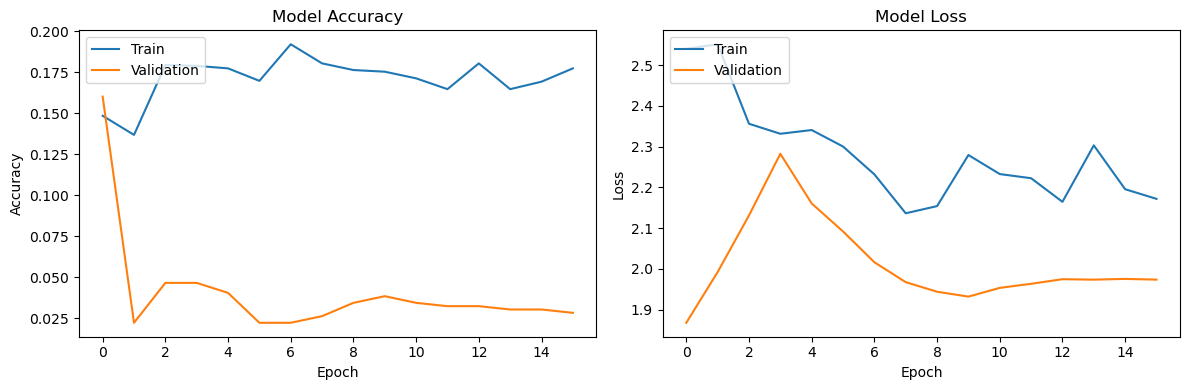

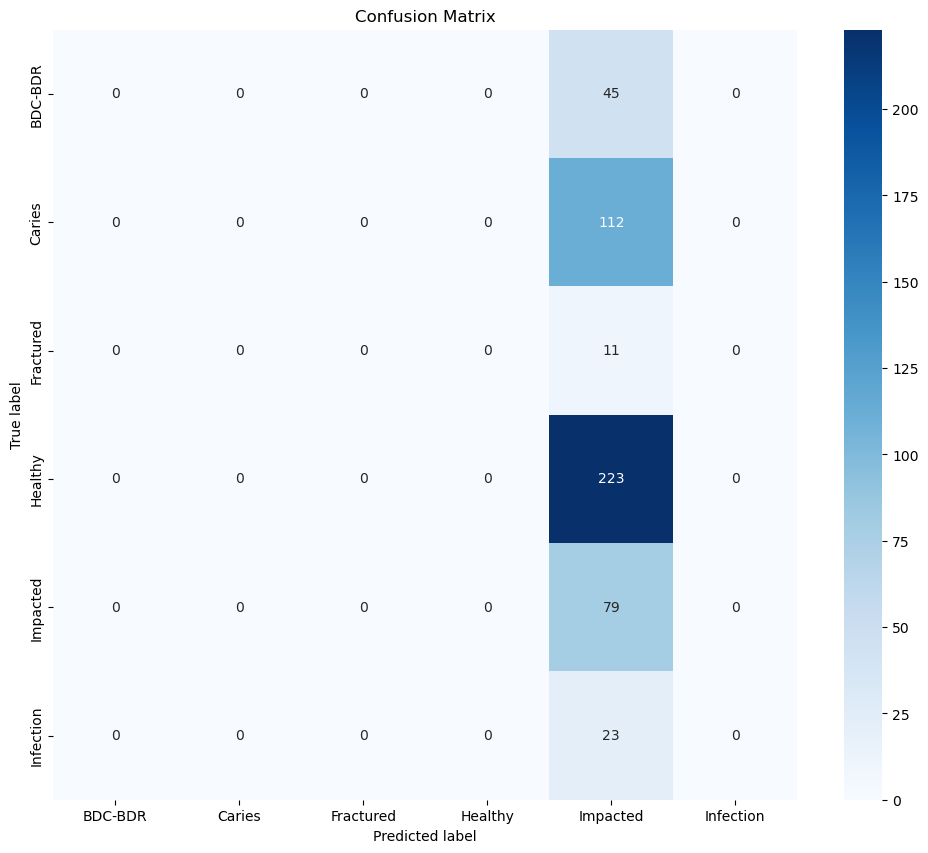

In [9]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import Counter
import seaborn as sns  # For enhanced visualization of confusion matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
import boto3
import io  # For handling in-memory image data

# AWS S3 Configuration
BUCKET_NAME = "sagemaker-studio-010526272250-hsf94lgtf6i"
INPUT_S3_PREFIX = "Mendeley_Data/Labeled_Dental_Dataset"
OUTPUT_S3_PREFIX = "Mendeley_Data"

# Local Folders (inside SageMaker environment)
output_folder = "processed_dental_images"
segmented_teeth_folder = "segmented_teeth"
model_folder = "models"
results_folder = "results"

# Create local output directories
for folder in [output_folder, segmented_teeth_folder, model_folder, results_folder]:
    os.makedirs(folder, exist_ok=True)

# Disease categories
disease_categories = ["BDC-BDR", "Caries", "Fractured", "Healthy", "Impacted", "Infection"]

# Initialize S3 client
s3 = boto3.client('s3')

# --- Utility Functions for S3 Interaction ---

def download_image_from_s3(bucket, key):
    """Downloads an image from S3 and returns it as a numpy array."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        image_data = obj['Body'].read()
        image_buffer = io.BytesIO(image_data)
        img_array = cv2.imdecode(np.frombuffer(image_buffer.read(), np.uint8), cv2.IMREAD_UNCHANGED)
        return img_array
    except Exception as e:
        print(f"Error downloading {key} from S3: {e}")
        return None

def upload_file_to_s3(filename, bucket, s3_key):
    """Uploads a local file to S3."""
    try:
        s3.upload_file(filename, bucket, s3_key)
        print(f"Uploaded {filename} to s3://{bucket}/{s3_key}")
    except Exception as e:
        print(f"Error uploading {filename} to S3: {e}")

def save_numpy_array_to_s3(array, bucket, s3_key):
    """Saves a numpy array to S3 as a .npy file."""
    try:
        buffer = io.BytesIO()
        np.save(buffer, array)
        buffer.seek(0)
        s3.put_object(Bucket=bucket, Key=s3_key, Body=buffer.read())
        print(f"Uploaded numpy array to s3://{bucket}/{s3_key}")
    except Exception as e:
        print(f"Error saving numpy array to S3: {e}")

def get_image_files_from_s3(bucket, prefix):
    """Lists all image files in the specified S3 prefix."""
    image_files = []
    try:
        response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
        if 'Contents' in response:
            for obj in response['Contents']:
                key = obj['Key']
                if key.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
                    image_files.append(key)
    except Exception as e:
        print(f"Error listing files in S3: {e}")
    return image_files

# Part 1: Image Preprocessing and Segmentation Functions

def get_disease_label(filename):
    """Extract disease label from the filename."""
    parts = filename.split('_')
    if parts and len(parts) > 0:
        label = parts[0]
        for category in disease_categories:
            if category.lower() in label.lower():
                return category
        if "BDC" in label.lower() or "bdr" in label.lower():
            return "BDC-BDR"
        if "Frac" in label.lower():
            return "Fractured"
        if "Health" in label.lower():
            return "Healthy"
        if "Impac" in label.lower():
            return "Impacted"
        if "Infec" in label.lower():
            return "Infection"

    return "Unknown"

def load_image(image_key):
    """Load image from S3 using boto3."""
    img = download_image_from_s3(BUCKET_NAME, image_key)
    if img is None:
        raise ValueError(f"Failed to load image from S3: s3://{BUCKET_NAME}/{image_key}")
    return img

def convert_one_channel(img):
    """Convert image to one channel if needed."""
    if len(img.shape) > 2:
        img = img[:, :, 0]
    return img

def convert_rgb(img):
    """Convert image to RGB if needed."""
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

def enhance_contrast(img):
    """Enhance image contrast using CLAHE."""
    if len(img.shape) == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)

        lab = cv2.merge((l, a, b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    return img

def improve_mask(mask):
    """Apply advanced morphological operations to improve segmentation."""
    kernel_open = np.ones((3, 3), dtype=np.uint8)
    kernel_close = np.ones((7, 7), dtype=np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    dist = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    _, sure_fg = cv2.threshold(dist, 0.7*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    return mask, sure_fg

def separate_touching_teeth(img, mask):
    """Use watershed algorithm to separate touching teeth."""
    mask, sure_fg = improve_mask(mask)

    sure_bg = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(convert_rgb(img), markers)

    result_mask = np.zeros_like(mask)
    result_mask[markers > 1] = 255

    return result_mask, markers

def filter_contours(cnts, min_area=100, max_area=20000):
    """Filter contours based on area and other properties."""
    filtered_cnts = []
    for cnt in cnts:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            if 0.2 < aspect_ratio < 5:
                hull = cv2.convexHull(cnt)
                hull_area = cv2.contourArea(hull)
                solidity = float(area) / hull_area if hull_area > 0 else 0
                if solidity > 0.5:
                    filtered_cnts.append(cnt)

    return filtered_cnts

def classify_teeth(img, cnts):
    """Classify teeth based on position and shape."""
    teeth_info = []

    height, width = img.shape[:2]

    midline_x = width // 2

    for i, cnt in enumerate(cnts):
        x, y, w, h = cv2.boundingRect(cnt)

        tooth = img[y:y+h, x:x+w]

        position = "upper" if y < height // 2 else "lower"

        side = "left" if x + (w // 2) < midline_x else "right"

        quadrant = 1 if position == "upper" and side == "right" else \
                   2 if position == "upper" and side == "left" else \
                   3 if position == "lower" and side == "left" else 4

        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00']) if M['m00'] != 0 else x + w // 2
        cy = int(M['m01'] / M['m00']) if M['m00'] != 0 else y + h // 2

        teeth_info.append({
            "contour": cnt,
            "position": position,
            "side": side,
            "quadrant": quadrant,
            "bbox": (x, y, w, h),
            "centroid": (cx, cy)
        })

    teeth_info.sort(key=lambda t: (t["position"] == "lower", t["centroid"][0]))

    return teeth_info

# Part 2: Segmentation Model Definition

def build_unet_model(input_size=(256, 256, 1)):
    """Build U-Net model for segmentation."""
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Part 3: Disease Classification Model

def build_classification_model(input_shape=(128, 128, 3), num_classes=6):
    """Build a CNN model for disease classification."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Part 4: Feature Extraction

def extract_features(tooth_img):
    """Extract features from a tooth image."""
    resized = cv2.resize(tooth_img, (128, 128), interpolation=cv2.INTER_LANCZOS4)
    resized = convert_rgb(resized)
    normalized = resized / 255.0
    return normalized

# Part 5: Data Processing Functions

def process_image_for_segmentation(image_key, segmentation_model):
    """Process a single image for teeth segmentation using the trained model."""
    try:
        img = load_image(image_key)
        original_img = img.copy()

        img_enhanced = enhance_contrast(img)

        if len(img_enhanced.shape) == 3:
            img_gray = cv2.cvtColor(img_enhanced, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img_enhanced

        img_resized = cv2.resize(img_gray, (256, 256), interpolation=cv2.INTER_LANCZOS4)
        img_normalized = np.float32(img_resized / 255)
        img_input = np.reshape(img_normalized, (1, 256, 256, 1))

        prediction = segmentation_model.predict(img_input)
        predicted = prediction[0, :, :, 0]

        predicted_resized = cv2.resize(predicted, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

        mask = np.uint8(predicted_resized * 255)
        _, binary_mask = cv2.threshold(mask, thresh=128, maxval=255, type=cv2.THRESH_BINARY)

        improved_mask, markers = separate_touching_teeth(img, binary_mask)

        cnts, _ = cv2.findContours(improved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        filtered_cnts = filter_contours(cnts)

        teeth_info = classify_teeth(original_img, filtered_cnts)

        return original_img, improved_mask, teeth_info
    except Exception as e:
        print(f"Error processing {image_key}: {str(e)}")
        return None, None, None

def extract_and_save_teeth(img, teeth_info, image_key, disease_label):
    """Extract, process, and save individual teeth with disease labels."""
    extracted_teeth = []

    if img is not None and teeth_info is not None:
        filename = os.path.splitext(os.path.basename(image_key))[0]

        for i, tooth in enumerate(teeth_info):
            try:
                x, y, w, h = tooth["bbox"]
                padding = 5
                x_pad = max(0, x - padding)
                y_pad = max(0, y - padding)
                w_pad = min(img.shape[1] - x_pad, w + 2*padding)
                h_pad = min(img.shape[0] - y_pad, h + 2*padding)

                tooth_img = img[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

                mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
                cv2.drawContours(mask, [tooth["contour"]], -1, 255, -1)
                tooth_mask = mask[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

                tooth_img_masked = cv2.bitwise_and(tooth_img, tooth_img, mask=tooth_mask)

                features = extract_features(tooth_img_masked)

                tooth_filename = f"{filename}_Q{tooth['quadrant']}_{tooth['position']}_{tooth['side']}_tooth_{i+1}_{disease_label}.png"
                tooth_path = os.path.join(segmented_teeth_folder, tooth_filename)
                cv2.imwrite(tooth_path, tooth_img_masked)  # Save locally

                # Upload the segmented tooth image to S3
                s3_tooth_key = os.path.join(OUTPUT_S3_PREFIX, segmented_teeth_folder, tooth_filename)
                upload_file_to_s3(tooth_path, BUCKET_NAME, s3_tooth_key)  # Upload to S3

                extracted_teeth.append({
                    'path': s3_tooth_key,  # Store S3 key
                    'features': features,
                    'disease': disease_label,
                    'quadrant': tooth['quadrant'],
                    'position': tooth['position'],
                    'side': tooth['side']
                })

            except Exception as e:
                print(f"Error extracting tooth {i+1} from {image_key}: {str(e)}")

    return extracted_teeth

# Part 6: Training Data Generation

def prepare_segmentation_data(image_files, target_size=(256, 256)):
    """Prepare data for training the segmentation model."""
    print("Preparing segmentation training data...")
    X = []
    y = []

    for image_key in tqdm(image_files[:100]):
        try:
            img = load_image(image_key)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
            img_resized = cv2.resize(img_gray, target_size, interpolation=cv2.INTER_LANCZOS4)
            img_normalized = img_resized / 255.0

            mask = cv2.adaptiveThreshold(
                img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, 11, 2
            )
            mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
            mask_normalized = mask_resized / 255.0

            X.append(img_normalized)
            y.append(mask_normalized)
        except Exception as e:
            print(f"Error preparing {image_key}: {str(e)}")

    X = np.array(X)
    y = np.array(y)

    X = X.reshape(-1, target_size[0], target_size[1], 1)
    y = y.reshape(-1, target_size[0], target_size[1], 1)

    return X, y

def create_classification_dataset(image_files):
    """Create a dataset for disease classification by segmenting teeth."""
    print("Creating classification dataset...")

    X_seg, y_seg = prepare_segmentation_data(image_files)

    X_train, X_val, y_train, y_val = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42)

    seg_model = build_unet_model(input_size=(256, 256, 1))

    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ModelCheckpoint(os.path.join(model_folder, 'segmentation_model.h5'), save_best_only=True, verbose=1)
    ]

    print("Training segmentation model...")
    seg_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=30,
        callbacks=callbacks
    )
    # Save the segmentation model to a local file
    segmentation_model_path = os.path.join(model_folder, 'segmentation_model.h5')
    seg_model.save(segmentation_model_path)
    # Upload the local segmentation model file to S3
    s3_segmentation_model_key = os.path.join(OUTPUT_S3_PREFIX, model_folder, 'segmentation_model.h5')
    upload_file_to_s3(segmentation_model_path, BUCKET_NAME, s3_segmentation_model_key)

    # Load the best model
    seg_model = tf.keras.models.load_model(segmentation_model_path)

    all_teeth = []

    for image_key in tqdm(image_files):
        try:
            disease_label = get_disease_label(os.path.basename(image_key))

            img, mask, teeth_info = process_image_for_segmentation(image_key, seg_model)

            if img is not None and teeth_info:
                teeth_data = extract_and_save_teeth(img, teeth_info, image_key, disease_label)
                all_teeth.extend(teeth_data)
        except Exception as e:
            print(f"Error processing {image_key} for classification: {str(e)}")

    return all_teeth

# Part 7: Training and Evaluation

def train_classification_model(teeth_data):
    """Train the classification model using extracted teeth data."""
    print("Training classification model...")

    X = np.array([tooth['features'] for tooth in teeth_data])
    diseases = [tooth['disease'] for tooth in teeth_data]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(diseases)

    # Save label encoder locally
    label_encoder_path = os.path.join(model_folder, 'label_encoder.npy')
    np.save(label_encoder_path, label_encoder.classes_)

    # Upload the label encoder file to S3
    s3_label_encoder_key = os.path.join(OUTPUT_S3_PREFIX, model_folder, 'label_encoder.npy')
    upload_file_to_s3(label_encoder_path, BUCKET_NAME, s3_label_encoder_key)

    y_categorical = tf.keras.utils.to_categorical(y_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    model = build_classification_model(input_shape=X.shape[1:], num_classes=len(np.unique(diseases)))

    callbacks = [
        EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
        ModelCheckpoint(os.path.join(model_folder, 'classification_model.h5'), save_best_only=True, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
    ]

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
    class_weight_dict = dict(enumerate(class_weights))

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    balanced_accuracy = balanced_accuracy_score(y_true_classes, y_pred_classes)
    report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Save results to local files
    report_path = os.path.join(results_folder, 'classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(f"Accuracy: {accuracy * 100:.2f}%\n")
        f.write(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_matrix))

    # Upload the classification report to S3
    s3_report_key = os.path.join(OUTPUT_S3_PREFIX, results_folder, 'classification_report.txt')
    upload_file_to_s3(report_path, BUCKET_NAME, s3_report_key)

    # Save training history plot to local file
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    history_plot_path = os.path.join(results_folder, 'training_history.png')
    plt.savefig(history_plot_path)

    # Upload the training history plot to S3
    s3_history_plot_key = os.path.join(OUTPUT_S3_PREFIX, results_folder, 'training_history.png')
    upload_file_to_s3(history_plot_path, BUCKET_NAME, s3_history_plot_key)

    # Plot confusion matrix with seaborn for better visualization and save to local file
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    confusion_matrix_path = os.path.join(results_folder, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_path)

    # Upload the confusion matrix plot to S3
    s3_confusion_matrix_key = os.path.join(OUTPUT_S3_PREFIX, results_folder, 'confusion_matrix.png')
    upload_file_to_s3(confusion_matrix_path, BUCKET_NAME, s3_confusion_matrix_key)

    # Save the classification model to a local file
    classification_model_path = os.path.join(model_folder, 'classification_model.h5')
    model.save(classification_model_path)

    # Upload the classification model to S3
    s3_classification_model_key = os.path.join(OUTPUT_S3_PREFIX, model_folder, 'classification_model.h5')
    upload_file_to_s3(classification_model_path, BUCKET_NAME, s3_classification_model_key)
    return model, accuracy, label_encoder.classes_, report

# Part 8: Post-processing and Visualization

def visualize_segmentation_results(image_key, disease_label, seg_model, teeth_info=None):
    """Create a visualization of the segmentation and classification results."""
    try:
        img = load_image(image_key)
        if teeth_info is None:
            _, _, teeth_info = process_image_for_segmentation(image_key, seg_model)
            if teeth_info is None:
                print(f"No teeth information available for {image_key}, skipping visualization.")
                return None

        vis_img = img.copy()
        vis_img = convert_rgb(vis_img)

        cv2.putText(vis_img, f"Disease: {disease_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        for tooth in teeth_info:
            x, y, w, h = tooth["bbox"]
            cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(vis_img, f"Q{tooth['quadrant']}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Save visualized image locally
        output_path = os.path.join(output_folder, f"visualized_{os.path.basename(image_key)}")
        cv2.imwrite(output_path, vis_img)
        print(f"Segmentation and visualization saved to {output_path}")

        # Upload the visualized image to S3
        s3_vis_key = os.path.join(OUTPUT_S3_PREFIX, output_folder, f"visualized_{os.path.basename(image_key)}")
        upload_file_to_s3(output_path, BUCKET_NAME, s3_vis_key)

        return s3_vis_key  # Return the S3 key
    except Exception as e:
        print(f"Error visualizing segmentation for {image_key}: {str(e)}")
        return None

# Part 9: Main Execution
if __name__ == "__main__":
    # Get image files from S3
    image_files = get_image_files_from_s3(BUCKET_NAME, INPUT_S3_PREFIX)
    print(f"Found {len(image_files)} image files in S3.")

    if not image_files:
        print("No image files found in S3. Check your bucket and prefix.")
    else:
        # Create classification dataset
        teeth_data = create_classification_dataset(image_files)
        print(f"Extracted {len(teeth_data)} teeth.")

        if not teeth_data:
            print("No teeth data extracted. Check segmentation and extraction steps.")
        else:
            # Train classification model
            model, accuracy, class_names, report = train_classification_model(teeth_data)
            print(f"Classification model trained with accuracy: {accuracy * 100:.2f}%")
            print("Classification Report:\n", report)

            # Load segmentation model (from local)
            seg_model_path = os.path.join(model_folder, 'segmentation_model.h5')
            seg_model = tf.keras.models.load_model(seg_model_path)
            print("Segmentation model loaded from local file.")

            # Visualize results on a few images
            num_visualizations = 5  # Adjust as needed
            for image_key in image_files[:num_visualizations]:
                disease_label = get_disease_label(os.path.basename(image_key))
                vis_s3_path = visualize_segmentation_results(image_key, disease_label, seg_model)

                if vis_s3_path:
                    print(f"Visualization saved for {image_key} to s3://{BUCKET_NAME}/{vis_s3_path}")
                else:
                    print(f"Visualization failed for {image_key}")

            print("Finished!")